In [2]:
import torch 
from matplotlib import pyplot as plt 
from tkgdti.train.utils import device_and_data_loading
import argparse 
from tkgdti.data.TriplesDatasetGNN import TriplesDatasetGNN
from tkgdti.data.process_graph import process_graph
import torch_geometric as pyg
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve 
import seaborn as sbn 

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from scipy.stats import rankdata
import os 
from tkgdti.eval.evaluate import evaluate

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
root = '../output/from_exacloud/tkge/'
dataset = '/GNN/' # complex2
k=10 

pred_ls = []
for fold in range(k):
    uid = [x for x in os.listdir(f'{root}{dataset}/FOLD_{fold}/') if os.path.isdir(f'{root}{dataset}/FOLD_{fold}/{x}')][0]
    preds = pd.read_csv(f'{root}{dataset}/FOLD_{fold}/{uid}/predictions.csv')
    preds = preds.assign(fold=fold)
    pred_ls.append(preds)
    

In [5]:
aurocs = [] 
for pred in pred_ls: 

    y = pred[lambda x: x.negatives | x.test].test.values
    yhat = pred[lambda x: x.negatives | x.test].prob.values
    auroc = roc_auc_score(y, yhat) 
    aurocs.append(auroc)

np.mean(aurocs)

0.9816854262950028

In [6]:
def get_test_ranks(preds): 

    rankdf = {'drug':[], 'protein':[], 'rank':[]}
    for drug in preds['drug'].unique():
        print(f'progress: {drug}', end='\r')
        drug_preds = preds[lambda x: (x.drug == drug)]

        for i,row in drug_preds[lambda x: x.test].iterrows():
            
            tmp = drug_preds[lambda x: x.negatives]
            rank = (tmp.score >= row.score).sum() + 1
            rankdf['drug'].append(row.drug)
            rankdf['protein'].append(row.protein)
            rankdf['rank'].append(rank)

    return pd.DataFrame(rankdf)


test_ranks = pd.concat([get_test_ranks(pred) for pred in pred_ls], axis=0, ignore_index=True)
test_ranks.head()


,drug,protein,rank
0,0,6676,14
1,0,7509,8
2,0,10863,37
3,1,3252,12
4,1,3619,5


In [7]:
mrr = np.mean(1/test_ranks['rank'])
top1 = (test_ranks['rank'] == 1).mean()
top3 = (test_ranks['rank'] <= 3).mean()
top5 = (test_ranks['rank'] <= 5).mean()
top10 = (test_ranks['rank'] <= 10).mean()
top100 = (test_ranks['rank'] <= 100).mean()

{'mrr':mrr, 'top1':top1, 'top3':top3, 'top5':top5, 'top10':top10, 'top100':top100}

{'mrr': 0.16541610457449835,
 'top1': 0.08477722772277228,
 'top3': 0.1766707920792079,
 'top5': 0.22834158415841585,
 'top10': 0.32425742574257427,
 'top100': 0.7592821782178217}

In [ ]:
'''

GNN --> 
tkge:
AUROC: 

tkge_no_patient:
AUROC: 

--------------------------------------------
COMPLEX2 --> 
tkge: 
AUROC: 
{'mrr': 0.1575234942115428,
 'top1': 0.07642326732673267,
 'top3': 0.1661509900990099,
 'top5': 0.22524752475247525,
 'top10': 0.3224009900990099,
 'top100': 0.7462871287128713}

tkge_no_patient:
AUROC: 0.982
{'mrr': 0.16541610457449835,
 'top1': 0.08477722772277228,
 'top3': 0.1766707920792079,
 'top5': 0.22834158415841585,
 'top10': 0.32425742574257427,
 'top100': 0.7592821782178217}
'''

In [8]:
topk = []
for i in range(5000): 
    topk.append( (test_ranks['rank'] <= i).mean() ) 

#np.save(f'../output/{dataset}/top@k.npy', topk)



In [9]:
max_rank = test_ranks['rank'].max()

#topk_gnn = np.load(f'../output/tkg/GNN/top@k.npy')
#topk_complex = np.load(f'../output/tkg/COMPLEX2/top@k.npy')

plt.figure(figsize=(4,4))
plt.plot(topk_gnn, label='GNN')
plt.plot(topk_complex, label='complex')
plt.xlabel('k')
plt.ylabel('Top@k')
plt.xscale('log')
plt.legend()
plt.grid()
plt.ylim(0.2,1)
plt.xlim(1,max_rank)
plt.show()

NameError: name 'topk_gnn' is not defined

<Figure size 400x400 with 0 Axes>

In [ ]:
preds = pd.concat([df[lambda x: x.negatives].assign(local_rank = lambda x: x.groupby('drug').rank(method='first', ascending=False).prob) for df in pred_ls], axis=0, ignore_index=True)
preds = preds.groupby(['drug','protein', 'drug_name', 'prot_name'])[['prob', 'local_rank']].mean()
preds.head()

prob  local_rank
drug protein drug_name                   prot_name                      
0    0       AAKJLRGGTJKAMG-UHFFFAOYSA-N A          0.316274      4817.7
     1       AAKJLRGGTJKAMG-UHFFFAOYSA-N A1BG       0.247165      7238.5
     2       AAKJLRGGTJKAMG-UHFFFAOYSA-N A1CF       0.293163      5719.9
     3       AAKJLRGGTJKAMG-UHFFFAOYSA-N A2M        0.419068      2528.0
     4       AAKJLRGGTJKAMG-UHFFFAOYSA-N A3GALT2    0.200309      8928.6

In [ ]:
ress = preds.assign(global_rank = lambda x: x.prob.rank(ascending=False))[lambda x: x.local_rank <= 25].sort_values('prob', ascending=False).reset_index()
meta = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/targetome__drug_targets_gene.csv')[['inhibitor', 'inchikey']].drop_duplicates()
ress = ress.reset_index().merge(meta, left_on='drug_name', right_on='inchikey', how='left').drop('inchikey', axis=1)
ress.head(25)

,index,drug,protein,drug_name,prot_name,prob,local_rank,global_rank,inhibitor
0,0,50,9326,ODPGGGTTYSGTGO-UHFFFAOYSA-N,PDGFRB,0.975473,1.3,1.0,AST-487
1,1,50,9325,ODPGGGTTYSGTGO-UHFFFAOYSA-N,PDGFRA,0.946697,2.3,2.0,AST-487
2,2,45,5990,MLDQJTXFUGDVEO-UHFFFAOYSA-N,KIT,0.940274,1.3,3.0,Sorafenib
3,3,50,5908,ODPGGGTTYSGTGO-UHFFFAOYSA-N,KDR,0.919425,9.9,4.0,AST-487
4,4,45,9325,MLDQJTXFUGDVEO-UHFFFAOYSA-N,PDGFRA,0.919177,1.7,5.0,Sorafenib
5,5,58,9326,PHXJVRSECIGDHY-UHFFFAOYSA-N,PDGFRB,0.911191,1.1,6.0,Ponatinib (AP24534)
6,6,60,4040,RAHBGWKEPAQNFF-UHFFFAOYSA-N,FLT3,0.898419,2.6,7.0,Motesanib (AMG-706)
7,7,78,10587,XXJWYDDUDKYVKI-UHFFFAOYSA-N,RET,0.893749,1.4,8.0,Cediranib (AZD2171)
8,8,46,10587,MPVGZUGXCQEXTM-UHFFFAOYSA-N,RET,0.891119,1.1,9.0,Linifanib (ABT-869)
9,9,45,4039,MLDQJTXFUGDVEO-UHFFFAOYSA-N,FLT1,0.885388,3.4,10.0,Sorafenib


In [ ]:
targ = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/targetome__drug_targets_gene.csv')
targ[lambda x: x.inhibitor == 'Canertinib (CI-1033)']

,inhibitor,Symbol,GeneID,targetome_adj_tier,can_smiles,inchikey,iso_smiles
132,Canertinib (CI-1033),EGFR,1956,TIER_1,C=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C...,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,C=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C...
142,Canertinib (CI-1033),ERBB2,2064,TIER_1,C=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C...,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,C=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C...
151,Canertinib (CI-1033),ERBB4,2066,TIER_1,C=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C...,OMZCMEYTWSXEPZ-UHFFFAOYSA-N,C=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C...


In [ ]:
ress[lambda x: x.inhibitor == 'Bosutinib (SKI-606)']

,index,drug,protein,drug_name,prot_name,prob,local_rank,global_rank,inhibitor
21,21,64,3413,UBPYILGKFZZVDX-UHFFFAOYSA-N,EGFR,0.878373,4.4,22.0,Bosutinib (SKI-606)
67,67,64,3623,UBPYILGKFZZVDX-UHFFFAOYSA-N,ERBB2,0.826448,12.7,68.0,Bosutinib (SKI-606)
82,82,64,3625,UBPYILGKFZZVDX-UHFFFAOYSA-N,ERBB4,0.812298,13.5,85.0,Bosutinib (SKI-606)
97,97,64,6602,UBPYILGKFZZVDX-UHFFFAOYSA-N,LYN,0.806080,13.7,102.0,Bosutinib (SKI-606)
98,98,64,1225,UBPYILGKFZZVDX-UHFFFAOYSA-N,BLK,0.805557,15.1,103.0,Bosutinib (SKI-606)


In [ ]:
plt.figure()
plt.scatter(preds['local_rank']['mean'].values, preds['local_rank']['std'].values)
plt.xlabel('mean rank')
plt.ylabel('std rank')
plt.show()

KeyError: 'mean'

<Figure size 640x480 with 0 Axes>

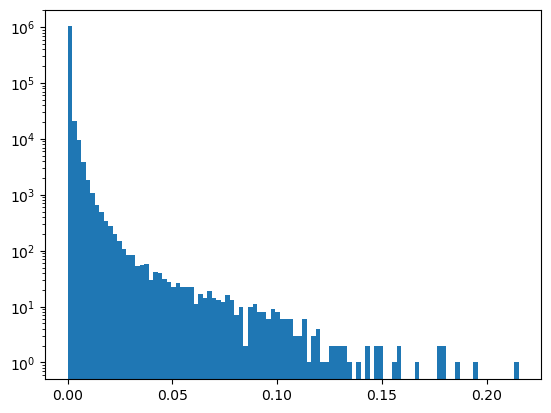

In [ ]:
plt.figure()
plt.hist(preds['prob'], bins=100)
plt.yscale('log')
plt.show()

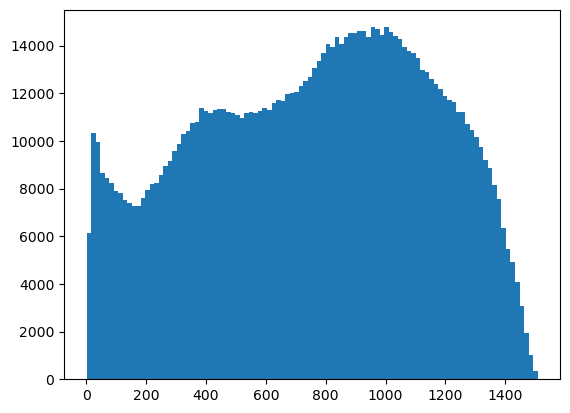

In [ ]:
plt.figure()
plt.hist(preds['local_rank'], bins=100)
#plt.yscale('log')
plt.show()

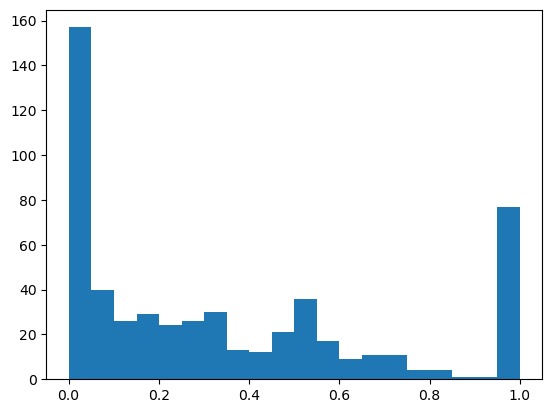

In [ ]:
# Calculate mrr for each drug
test_ranks['mrr'] = test_ranks.groupby('drug')['rank'].transform(lambda x: np.mean(1/x))

# Group by drug and aggregate mrr
# Count the number of proteins per drug
test_ranks['n'] = test_ranks.groupby('drug')['protein'].transform('count')

# Group by drug and aggregate mrr and protein_count
drug_perf = test_ranks.groupby('drug').agg({'mrr': 'mean', 'n':'mean'}).sort_values('mrr', ascending=False)

plt.figure()
plt.hist(drug_perf.mrr, bins=20)
plt.show()

In [ ]:
targdf = pd.read_csv('../extdata/meta/targetome__drug_targets_gene.csv')
targdf.head()

,inhibitor,Symbol,GeneID,targetome_adj_tier,can_smiles,inchikey,iso_smiles
0,ABT-737,BAD,572,TIER_1,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,HPLNQCPCUACXLM-PGUFJCEWSA-N,CN(C)CC[C@H](CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O...
1,Palbociclib,CCND1,595,TIER_1,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,AHJRHEGDXFFMBM-UHFFFAOYSA-N,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...
2,Flavopiridol,CCNT1,904,TIER_1,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CN1CC[C@@H]([C@@H](C1)O)C2=C(C=C(C3=C2OC(=CC3=...
3,Bortezomib (Velcade),PSMA1,5682,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...
4,Bortezomib (Velcade),PSMA2,5683,TIER_1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,GXJABQQUPOEUTA-RDJZCZTQSA-N,B([C@H](CC(C)C)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)...


In [ ]:
neg_preds = pd.concat(pred_ls, axis=0, ignore_index=True)[lambda x: x.negatives]
neg_preds = neg_preds.groupby(['drug_name', 'prot_name']).prob.mean().reset_index()
neg_preds = neg_preds.assign(global_rank = neg_preds.prob.rank(ascending=False))
neg_preds = neg_preds.assign(drug_rank = neg_preds.groupby('drug_name').prob.rank(ascending=False))
neg_preds = neg_preds.merge(targdf[['inhibitor', 'inchikey']].drop_duplicates(), left_on='drug_name', right_on='inchikey', how='left').drop('drug_name', axis=1)
neg_preds.head()


,prot_name,prob,global_rank,drug_rank,inhibitor,inchikey
0,A6NG28,0.366816,862100.0,1324.0,NaN,NaN
1,O00141,0.472624,133659.0,253.0,NaN,NaN
2,O00180,0.517583,45595.0,82.0,NaN,NaN
3,O00187,0.466439,155405.0,303.0,NaN,NaN
4,O00204,0.457199,194739.0,379.0,NaN,NaN


In [ ]:
clue = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')[['inchi_key', 'target']].drop_duplicates().dropna().assign(in_clue=True)
clue = clue.rename({'inchi_key':'inchikey', 'target':'prot_name'}, axis=1)
clue.head()

,inchikey,prot_name,in_clue
602,OCJYIGYOJCODJL-UHFFFAOYSA-N,NR1I3,True
603,BAFKRPOFIYPKBQ-UHFFFAOYSA-N,NR1I3,True
604,JMIFGARJSWXZSH-UHFFFAOYSA-N,ACVR1,True
605,GRZXWCHAXNAUHY-NSISKUIASA-N,AKT3,True
606,GRZXWCHAXNAUHY-NSISKUIASA-N,AKT1,True


In [ ]:
neg_preds = neg_preds.merge(clue,on=['inchikey', 'prot_name'], how='left').sort_values('global_rank').fillna(False)
neg_preds.head(10)

/tmp/ipykernel_3556/2126281206.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  neg_preds = neg_preds.merge(clue,on=['inchikey', 'prot_name'], how='left').sort_values('global_rank').fillna(False)


,prot_name,prob,global_rank,drug_rank,inhibitor,inchikey,in_clue
905501,P48169,0.885448,1.0,1.0,False,False,False
1050009,P41143,0.864302,2.0,1.0,False,False,False
1034949,P28221,0.860897,3.0,1.0,False,False,False
149847,P41145,0.852213,4.0,1.0,False,False,False
669868,P31645,0.848058,5.0,1.0,False,False,False
555201,P41145,0.846034,6.0,1.0,False,False,False
579108,P48169,0.845535,7.0,1.0,False,False,False
551946,P19793,0.841990,8.0,1.0,False,False,False
560678,P08912,0.840037,9.0,1.0,False,False,False
905331,P30536,0.835340,10.0,2.0,False,False,False


In [ ]:
# clue rank 

clue_mrr = np.mean(1/neg_preds[lambda x: x.in_clue].drug_rank)
clue_top1 = (neg_preds[lambda x: x.in_clue].drug_rank == 1).mean()
clue_top3 = (neg_preds[lambda x: x.in_clue].drug_rank <= 3).mean()
clue_top5 = (neg_preds[lambda x: x.in_clue].drug_rank <= 5).mean()
clue_top10 = (neg_preds[lambda x: x.in_clue].drug_rank <= 10).mean()
n_clue = neg_preds[lambda x: x.in_clue].shape[0]

{'mrr':clue_mrr, 'top1':clue_top1, 'top3':clue_top3, 'top5':clue_top5, 'top10':clue_top10, 'n_clue':n_clue}

{'mrr': nan, 'top1': nan, 'top3': nan, 'top5': nan, 'top10': nan, 'n_clue': 0}

In [ ]:
gene2aa = pd.read_csv('../extdata/meta/gene2aa.csv')
gene2aa = gene2aa.assign(uniprot= [x.split('|')[1] for x in gene2aa['id'].values])
gene2aa = gene2aa[['gene_name', 'uniprot']].drop_duplicates()
gene2aa = gene2aa.groupby('gene_name').first().reset_index()
gene2aa.head()

,gene_name,uniprot
0,A1BG,P04217
1,A1CF,Q9NQ94
2,A2M,P01023
3,A3GALT2,U3KPV4
4,A4GALT,Q9NPC4


In [ ]:
stitch = pd.read_csv('/home/teddy/local/gsnn-lib/extdata/processed_stitch_targets.csv')
brd2inchi = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')[['inchi_key', 'pert_id']].drop_duplicates()
stitch = stitch.merge(brd2inchi, on='pert_id', how='left')
stitch = stitch.rename({'inchi_key':'inchikey', 'combined_score':'stitch_score'}, axis=1)
stitch = stitch.assign(in_stitch=True)
stitch = stitch.merge(gene2aa, left_on='target', right_on='uniprot', how='inner').rename({'gene_name':'prot_name'}, axis=1)
stitch= stitch[['prot_name', 'inchikey', 'in_stitch', 'stitch_score']]
stitch.head()

,prot_name,inchikey,in_stitch,stitch_score
0,RET,KDGFLJKFZUIJMX-UHFFFAOYSA-N,True,800
1,ALK,KDGFLJKFZUIJMX-UHFFFAOYSA-N,True,968
2,STAT3,KDGFLJKFZUIJMX-UHFFFAOYSA-N,True,815
3,HCRTR2,JYTNQNCOQXFQPK-MRXNPFEDSA-N,True,962
4,HCRTR1,JYTNQNCOQXFQPK-MRXNPFEDSA-N,True,971


In [ ]:
neg_preds = neg_preds.merge(stitch, on=['inchikey', 'prot_name'], how='left').sort_values('global_rank')
neg_preds.in_stitch = neg_preds.in_stitch.fillna(False)
neg_preds.head(10)

/tmp/ipykernel_3556/1559203535.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  neg_preds.in_stitch = neg_preds.in_stitch.fillna(False)


,prot_name,prob,global_rank,drug_rank,inhibitor,inchikey,in_clue,in_stitch,stitch_score
0,P48169,0.885448,1.0,1.0,False,False,False,False,NaN
1,P41143,0.864302,2.0,1.0,False,False,False,False,NaN
2,P28221,0.860897,3.0,1.0,False,False,False,False,NaN
3,P41145,0.852213,4.0,1.0,False,False,False,False,NaN
4,P31645,0.848058,5.0,1.0,False,False,False,False,NaN
5,P41145,0.846034,6.0,1.0,False,False,False,False,NaN
6,P48169,0.845535,7.0,1.0,False,False,False,False,NaN
7,P19793,0.841990,8.0,1.0,False,False,False,False,NaN
8,P08912,0.840037,9.0,1.0,False,False,False,False,NaN
9,P30536,0.835340,10.0,2.0,False,False,False,False,NaN


In [ ]:
# stitch res 

stitch_mrr = np.mean(1/neg_preds[lambda x: x.in_stitch].drug_rank)
stitch_top1 = (neg_preds[lambda x: x.in_stitch].drug_rank == 1).mean()
stitch_top3 = (neg_preds[lambda x: x.in_stitch].drug_rank <= 3).mean()
stitch_top5 = (neg_preds[lambda x: x.in_stitch].drug_rank <= 5).mean()
stitch_top10 = (neg_preds[lambda x: x.in_stitch].drug_rank <= 10).mean()
n_stitch = neg_preds[lambda x: x.in_stitch].shape[0]

{'mrr':stitch_mrr, 'top1':stitch_top1, 'top3':stitch_top3, 'top5':stitch_top5, 'top10':stitch_top10, 'n_stitch':n_stitch}

{'mrr': nan,
 'top1': nan,
 'top3': nan,
 'top5': nan,
 'top10': nan,
 'n_stitch': 0}

In [ ]:
neg_preds.head(100).in_stitch.sum()

0

In [ ]:
neg_preds.tail(100).in_stitch.sum()

0

In [ ]:
neg_preds.head(100).in_clue.sum()

0

In [ ]:
neg_preds.tail(100).in_clue.sum()

0

In [ ]:
kd_preds = pd.read_csv('../output/kd/predictions.csv').rename({'gene_symbol':'prot_name'}, axis=1)
neg_preds = neg_preds.merge(kd_preds, on=['inchikey', 'prot_name'], how='left')
neg_preds.head(10)

,prot_name,prob,global_rank,drug_rank,inhibitor,inchikey,in_clue,in_stitch,stitch_score,drug_idx,prot_idx,in_targetome,kd_score,kd_lcb,kd_ucb
0,P48169,0.885448,1.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P41143,0.864302,2.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P28221,0.860897,3.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P41145,0.852213,4.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P31645,0.848058,5.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,P41145,0.846034,6.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,P48169,0.845535,7.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,P19793,0.841990,8.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,P08912,0.840037,9.0,1.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,P30536,0.835340,10.0,2.0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
neg_preds.head(10).kd_score.mean()

nan

In [ ]:
neg_preds.tail(1000).kd_score.dropna().mean()

nan

In [ ]:
expr = pd.read_csv('../data/tkg_raw/beataml_waves1to4_counts_dbgap.txt', sep='\t')[lambda x: x.biotype == 'protein_coding']
expr = expr[['display_label'] + list(expr.columns[4:])]
expr = expr.groupby('display_label').mean().reset_index()
expr.head()

,display_label,BA2392R,BA2611R,BA2506R,BA2430R,BA2448R,BA2730R,BA2845R,BA2326R,BA2341R,...,BA3376R,BA3137R,BA3300R,BA3375R,BA3249R,BA3385R,BA3242R,BA3446R,BA3416R,BA3123R
0,A1BG,30.0,13.0,21.0,19.0,13.0,10.0,28.0,26.0,37.0,...,26.0,14.0,10.0,9.0,19.0,22.0,18.0,18.0,30.0,26.0
1,A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A2M,178.0,120.0,184.0,163.0,155.0,107.0,256.0,248.0,196.0,...,3.0,129.0,1.0,1.0,0.0,9.0,45.0,0.0,2.0,11.0
3,A2ML1,0.0,3.0,1.0,5.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,A3GALT2,3.0,2.0,7.0,4.0,3.0,2.0,15.0,10.0,14.0,...,2.0,7.0,3.0,20.0,7.0,1.0,8.0,9.0,3.0,6.0


In [ ]:
expressed_aml_genes = expr.set_index('display_label').mean(axis=1)
q = expressed_aml_genes.quantile(0.9)
print(q)
hi_expr_aml_genes = expressed_aml_genes[expressed_aml_genes > q].index
no_expr_aml_genes = expressed_aml_genes[expressed_aml_genes < 1].index
print('# highly expressed aml genes:', len(hi_expr_aml_genes)) 
print('# not expressed aml genes:', len(no_expr_aml_genes))

4125.294483734088
# highly expressed aml genes: 2054
# not expressed aml genes: 3842


In [ ]:
neg_preds = neg_preds.assign(hi_expr_in_aml = [x in hi_expr_aml_genes for x in neg_preds.prot_name])
neg_preds = neg_preds.assign(no_expr_in_aml = [x in no_expr_aml_genes for x in neg_preds.prot_name])
neg_preds[lambda x: x.hi_expr_in_aml].head(10)

,prot_name,prob,global_rank,drug_rank,inhibitor,inchikey,in_clue,in_stitch,stitch_score,drug_idx,prot_idx,in_targetome,kd_score,hi_expr_in_aml,no_expr_in_aml
1,KIT,0.934837,2.0,1.0,Sorafenib,MLDQJTXFUGDVEO-UHFFFAOYSA-N,True,True,997.0,29.0,5631.0,False,-0.515318,True,False
4,FLT3,0.932110,5.0,1.0,Motesanib (AMG-706),RAHBGWKEPAQNFF-UHFFFAOYSA-N,False,True,788.0,28.0,3804.0,False,0.087434,True,False
14,KIT,0.905576,15.0,2.0,Imatinib,KTUFNOKKBVMGRW-UHFFFAOYSA-N,True,True,999.0,7.0,5631.0,False,-0.381547,True,False
18,KIT,0.903603,19.0,1.0,Crenolanib,DYNHJHQFHQTFTP-UHFFFAOYSA-N,False,False,NaN,55.0,5631.0,False,-0.334086,True,False
19,FLT3,0.902113,20.0,2.0,Cediranib (AZD2171),XXJWYDDUDKYVKI-UHFFFAOYSA-N,False,False,NaN,58.0,3804.0,False,-0.027038,True,False
26,CSF1R,0.893838,27.0,3.0,Cediranib (AZD2171),XXJWYDDUDKYVKI-UHFFFAOYSA-N,False,True,893.0,58.0,2430.0,False,-0.295062,True,False
27,CSF1R,0.891340,28.0,4.0,Sorafenib,MLDQJTXFUGDVEO-UHFFFAOYSA-N,False,True,944.0,29.0,2430.0,False,-0.018232,True,False
32,CDK9,0.890620,33.0,1.0,R547,JRNJNYBQQYBCLE-UHFFFAOYSA-N,False,True,875.0,73.0,1779.0,False,-0.461739,True,False
36,FLT3,0.888214,37.0,2.0,Ponatinib (AP24534),PHXJVRSECIGDHY-UHFFFAOYSA-N,True,True,986.0,10.0,3804.0,False,0.026145,True,False
41,CSF1R,0.883671,42.0,1.0,Sunitinib,WINHZLLDWRZWRT-ATVHPVEESA-N,False,True,986.0,57.0,2430.0,False,-0.405000,True,False


In [ ]:
neg_preds.head(1000).to_csv('/mnt/c/Users/natha/Documents/TKGDTI_top1000_negative_predictions-01-13-2025.csv', index=False)
neg_preds.to_csv('../output/tkg/TKGDTI_negative_predictions.csv', index=False)

In [ ]:
#SCITEAI - possible resource for filtering/identifying unknown target predictions 
# OHSU has license 

# once we find a aml target we think is novel, compare to beataml to look for sensitivity. 

# could use molecular docking software to predict binding affinity 

-0.03235370096350909


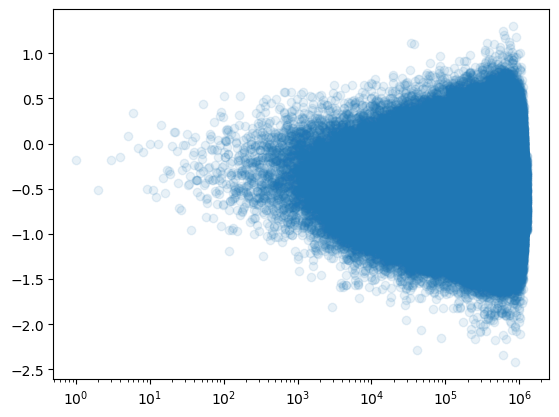

In [ ]:
print(np.corrcoef(neg_preds[lambda x: ~x.kd_score.isna()].global_rank, neg_preds[lambda x: ~x.kd_score.isna()].kd_score)[0,1])
plt.figure()
plt.plot(neg_preds.global_rank, neg_preds.kd_score, 'o', alpha=0.1)
plt.xscale('log')
plt.show()

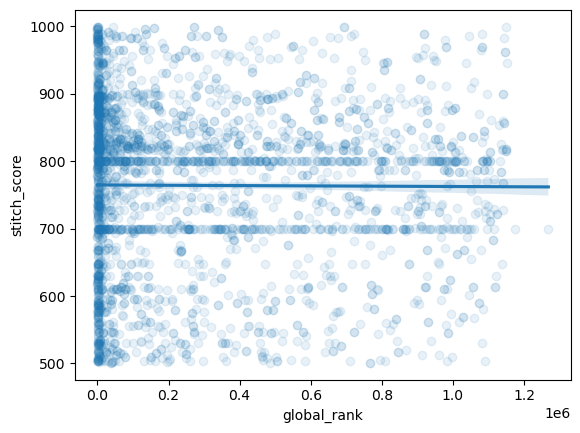

In [ ]:
plt.figure()
sbn.regplot(x='global_rank', y='stitch_score', data=neg_preds, scatter_kws={'alpha':0.1})
plt.show()

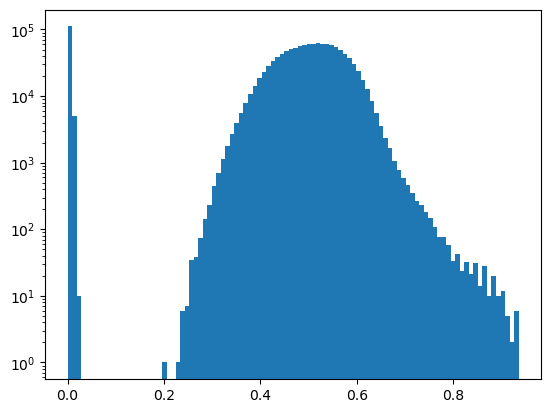

In [ ]:
plt.figure()
plt.hist(neg_preds['prob'], bins=100)
plt.yscale('log')
plt.show()

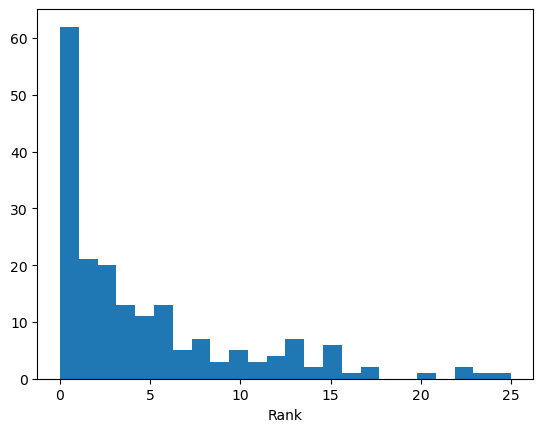

In [ ]:
plt.figure()
plt.hist(test_ranks['rank'], bins=np.linspace(0,25,25))
plt.xlabel('Rank')
plt.show()

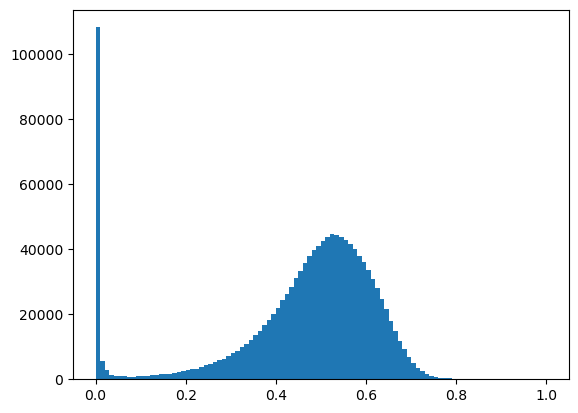

In [ ]:
plt.figure()
plt.hist(preds['prob'], bins=100)
plt.show()

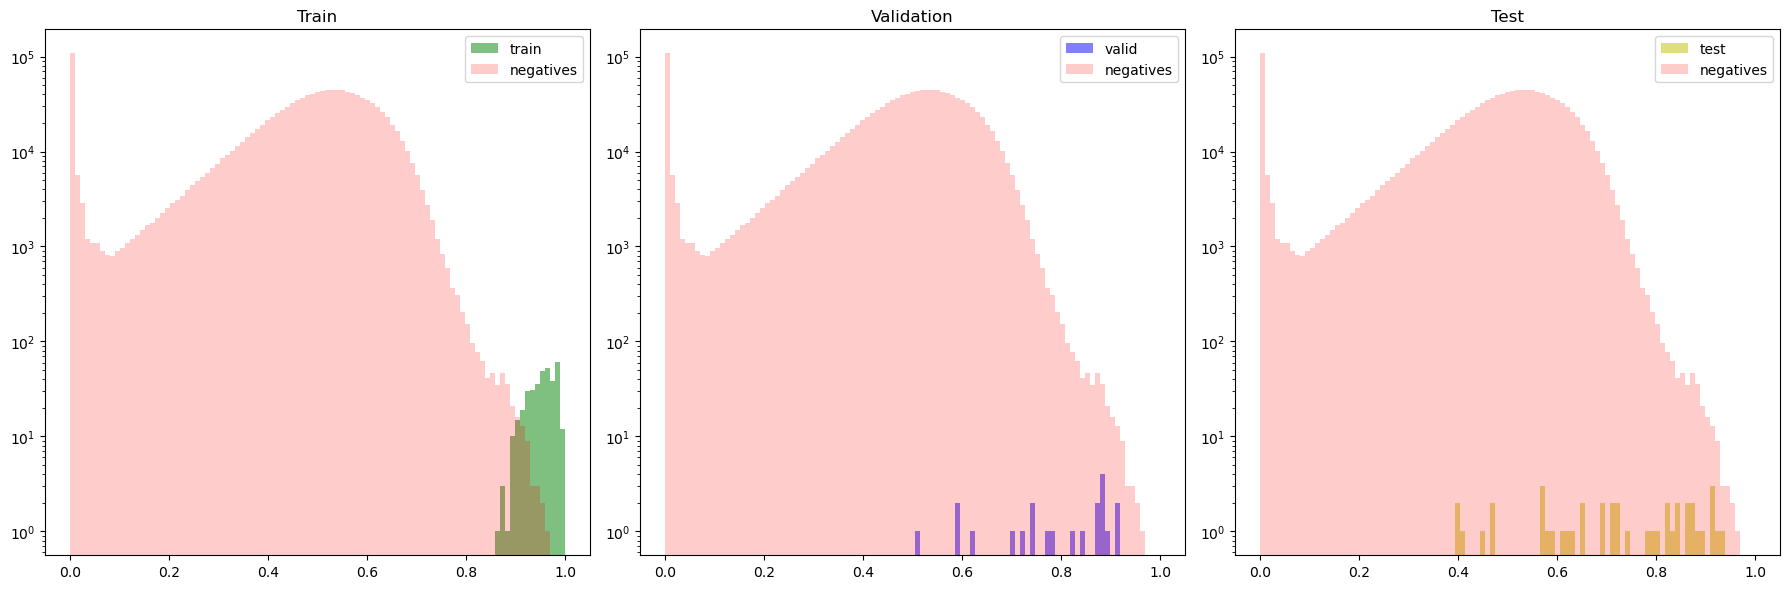

In [ ]:
def plot_hists(df, figsize=(18, 6), density=False): 

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    _bins = np.linspace(0, 1, 100)

    axs[0].hist(df[df.train].prob, alpha=0.5, label='train', color='g', density=density, bins=_bins)
    axs[0].hist(df[df.negatives].prob, alpha=0.2, label='negatives', color='r', density=density, bins=_bins)
    axs[0].legend()
    axs[0].set_yscale('log')
    axs[0].set_title('Train')

    axs[1].hist(df[df.valid].prob, alpha=0.5, label='valid', color='b', density=density, bins=_bins)
    axs[1].hist(df[df.negatives].prob, alpha=0.2, label='negatives', color='r', density=density, bins=_bins)
    axs[1].legend()
    axs[1].set_yscale('log')
    axs[1].set_title('Validation')

    axs[2].hist(df[df.test].prob, alpha=0.5, label='test', color='y', density=density, bins=_bins)
    axs[2].hist(df[df.negatives].prob, alpha=0.2, label='negatives', color='r', density=density, bins=_bins)
    axs[2].legend()
    axs[2].set_yscale('log')
    axs[2].set_title('Test')

    plt.tight_layout()

    plt.show()

plot_hists(preds)

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


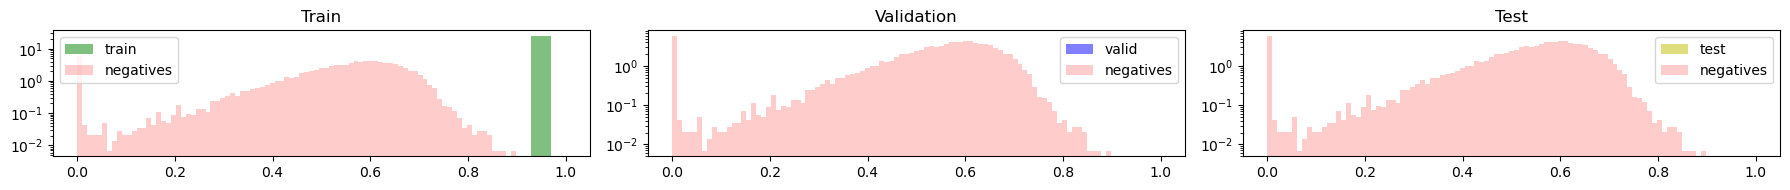

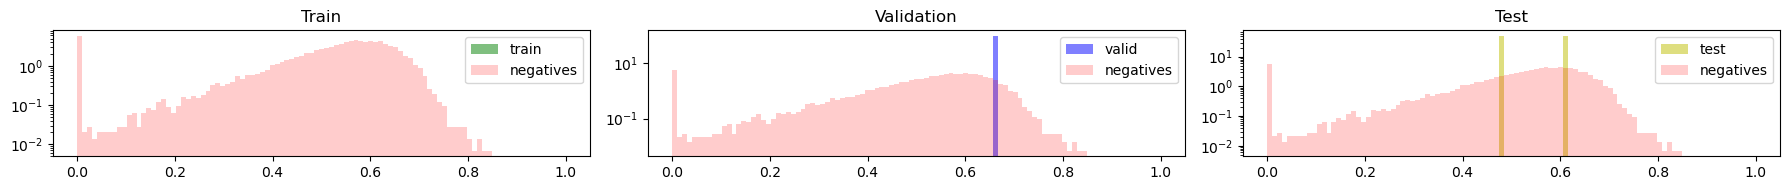

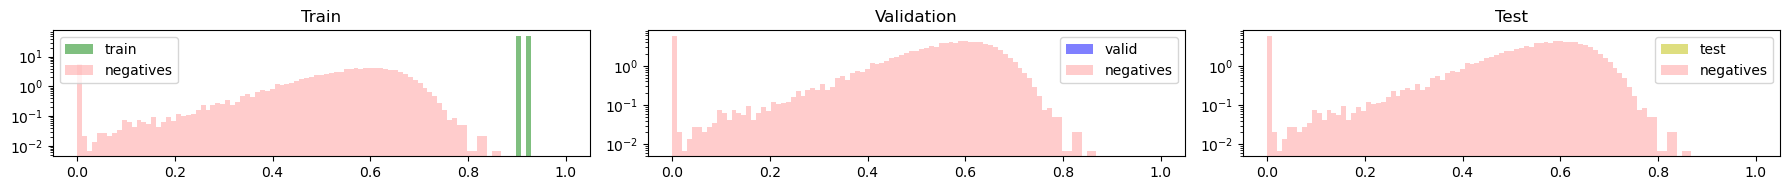

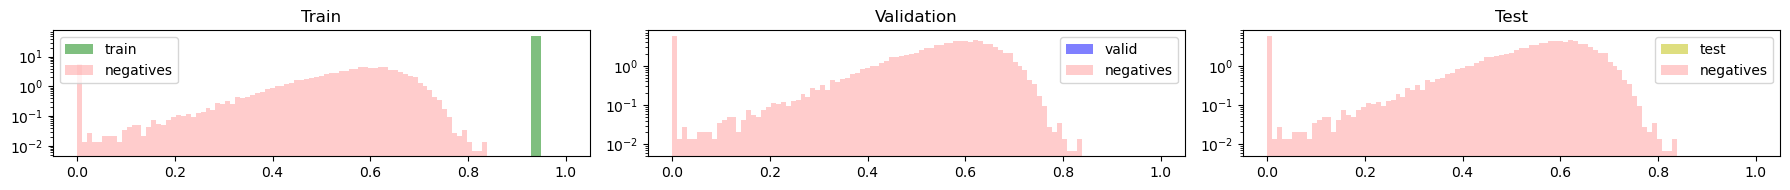

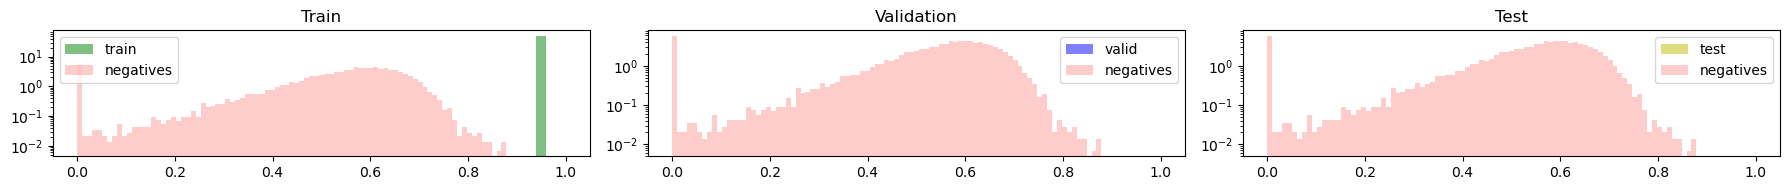

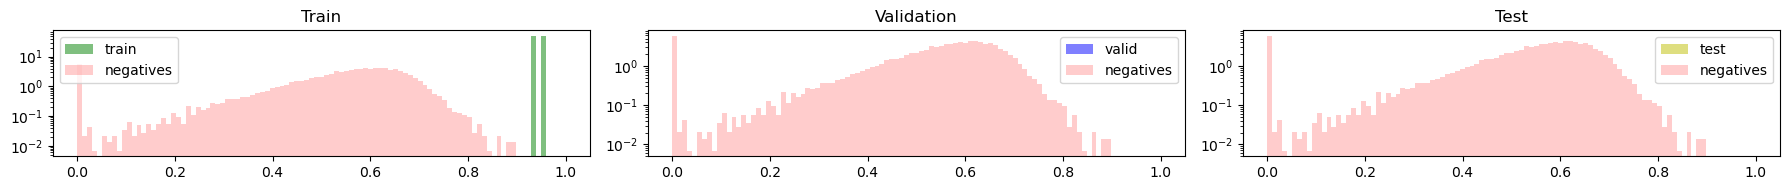

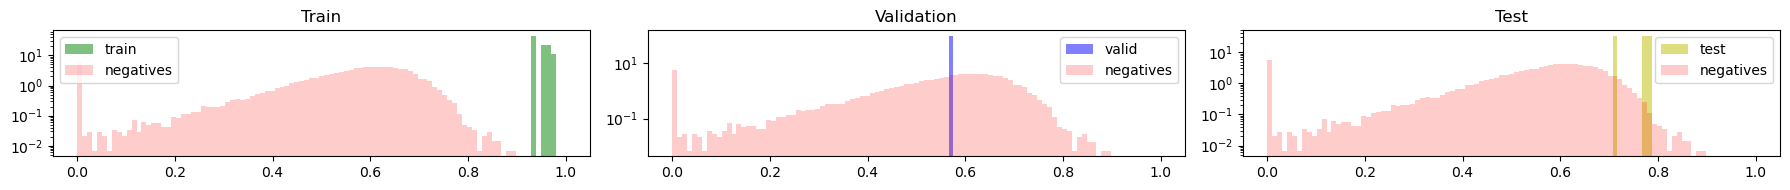

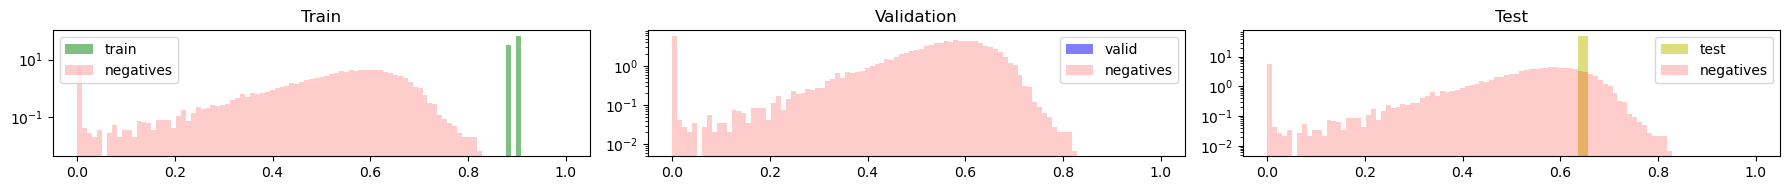

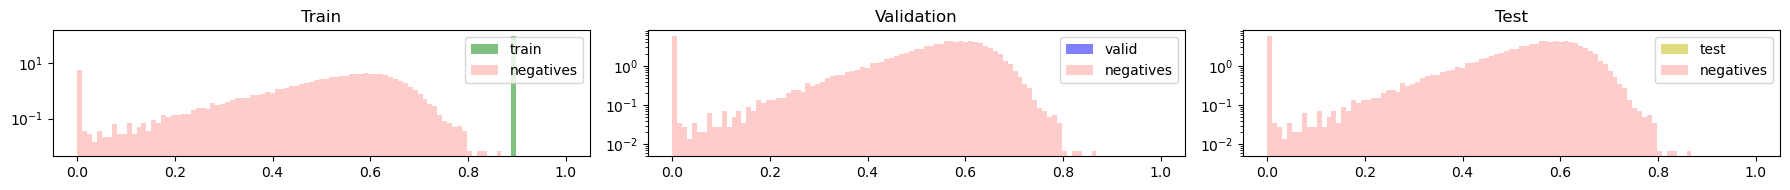

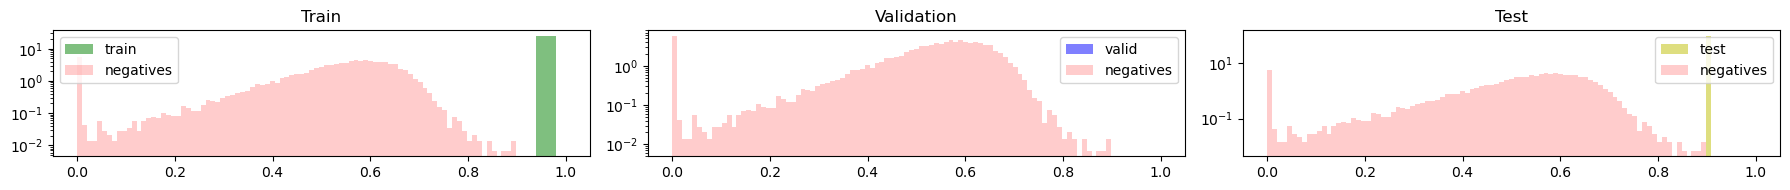

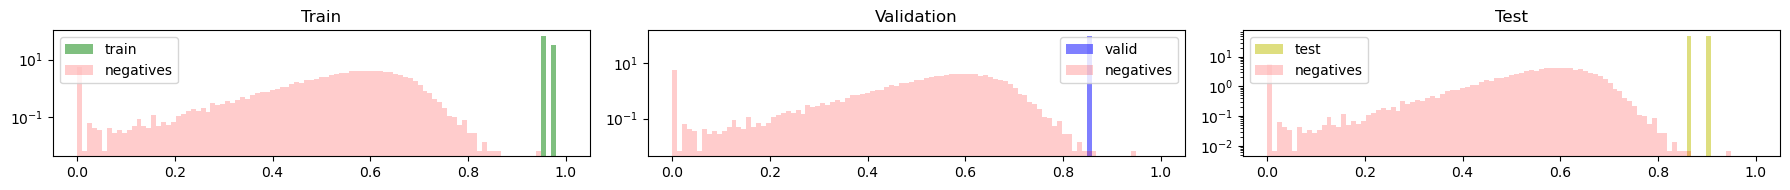

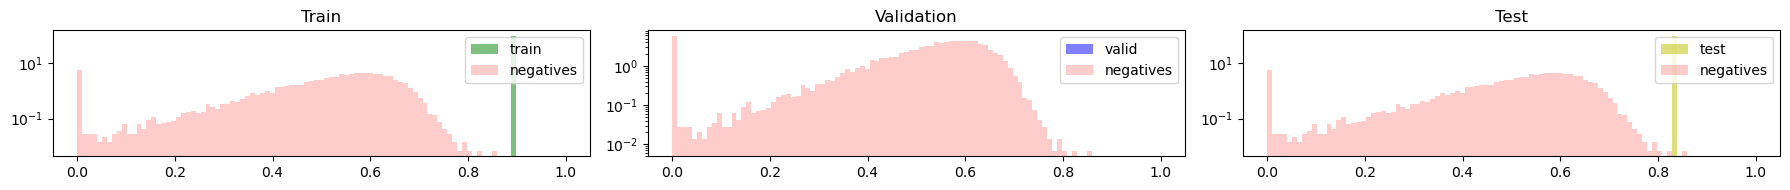

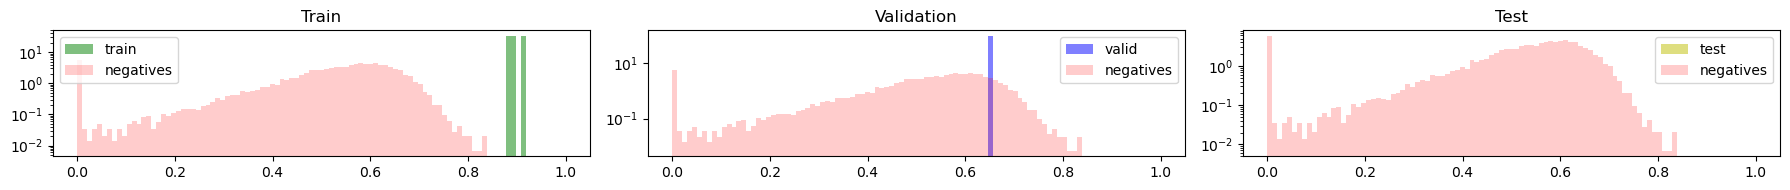

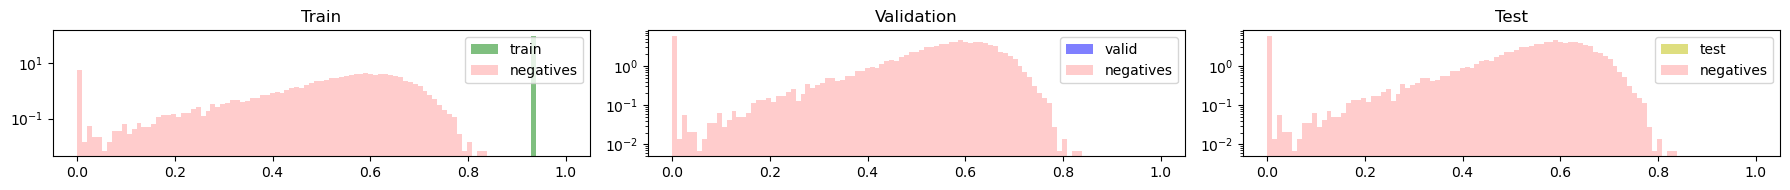

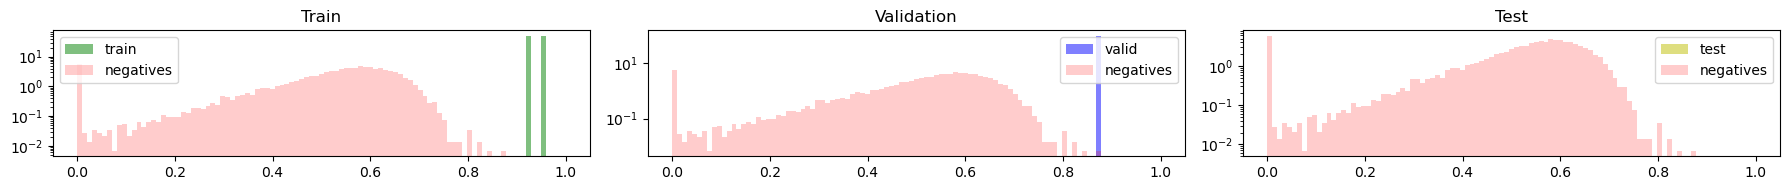

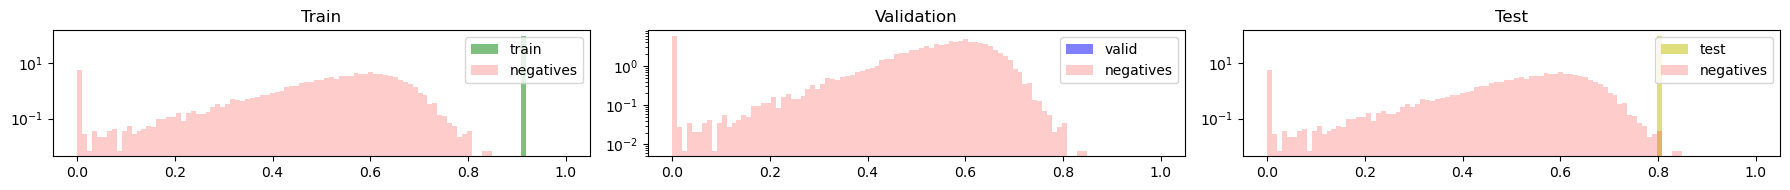

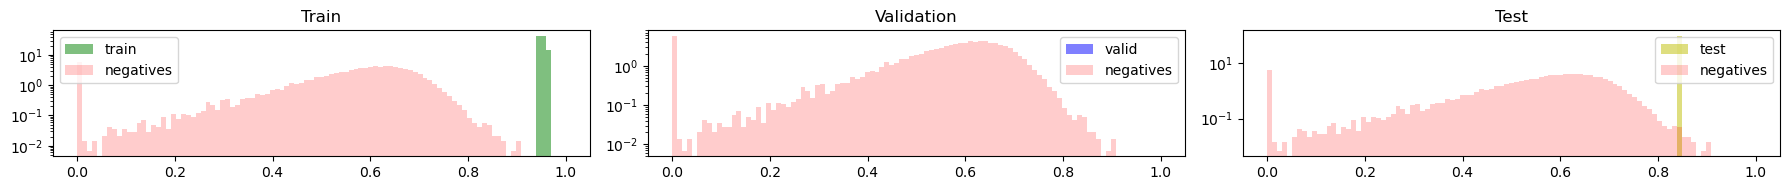

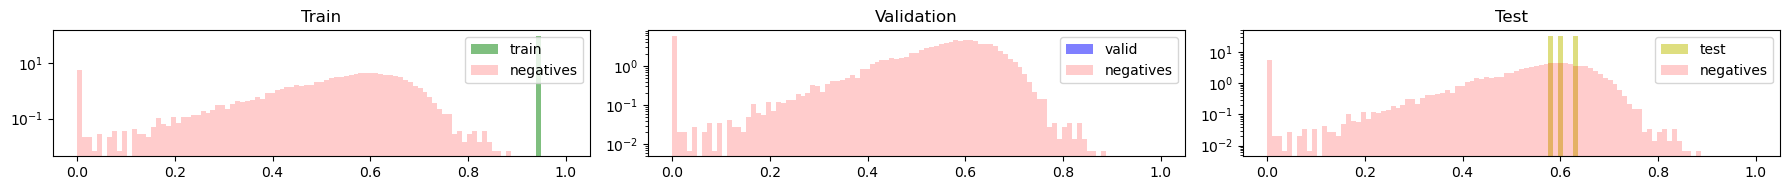

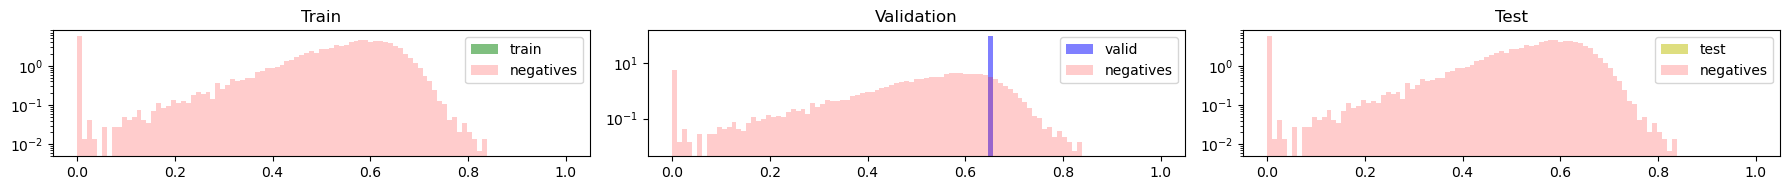

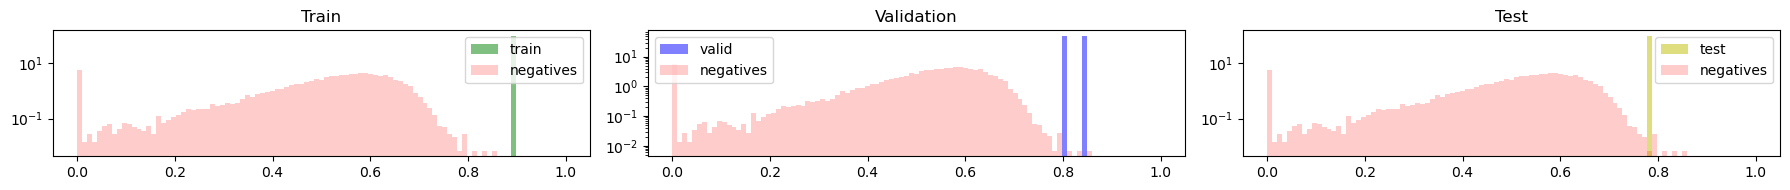

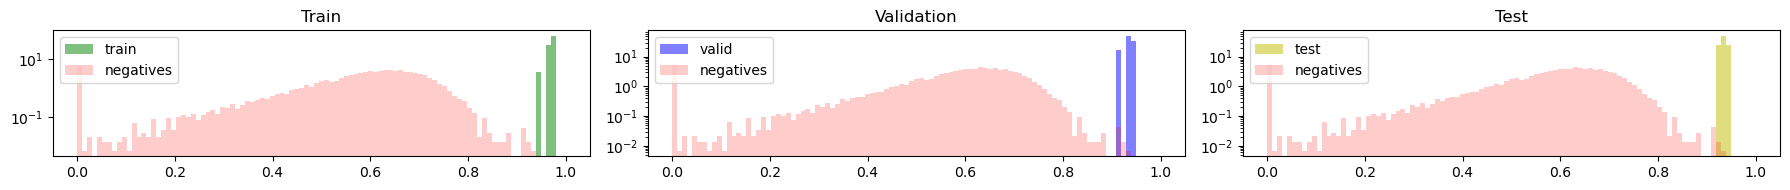

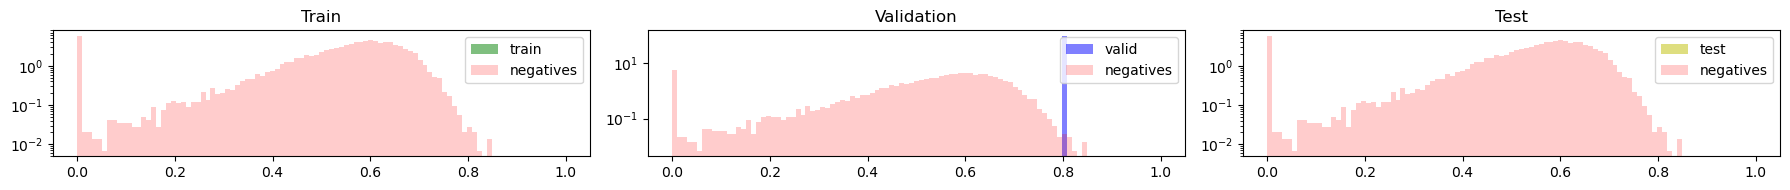

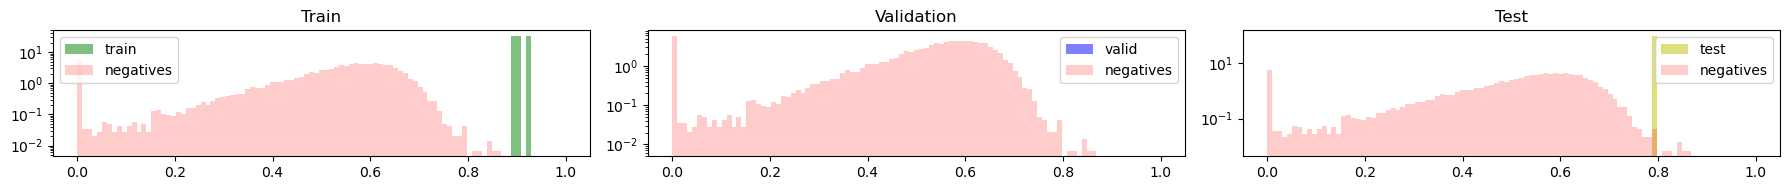

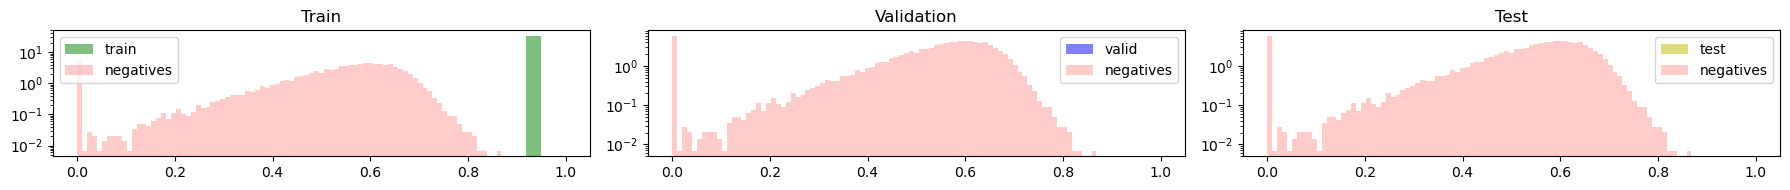

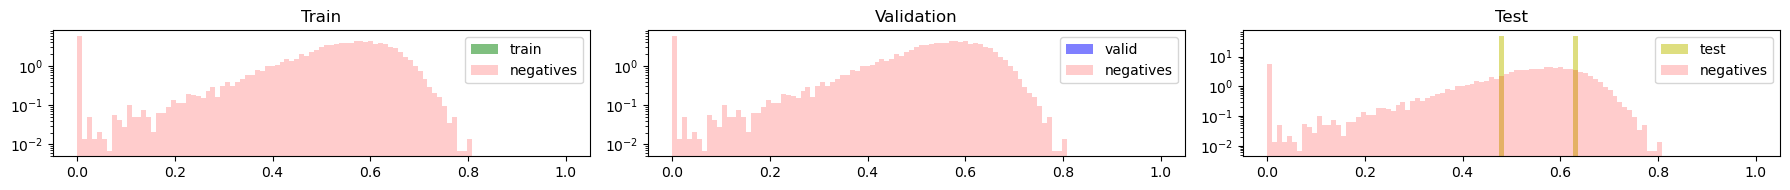

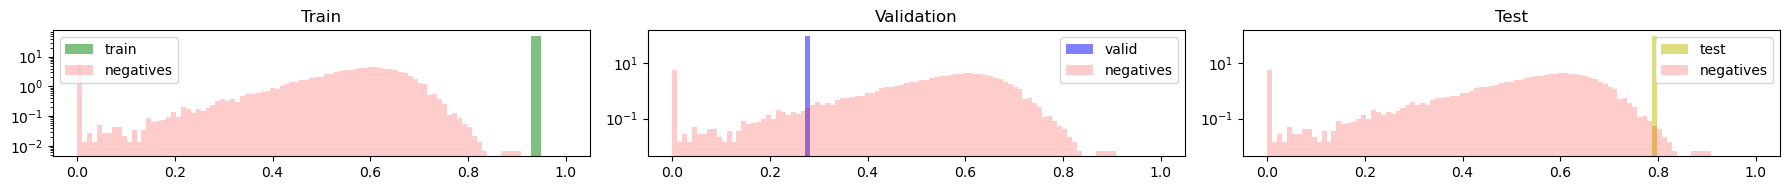

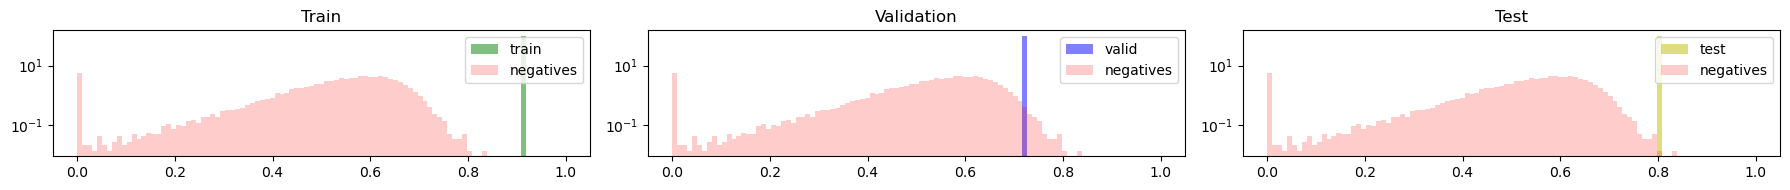

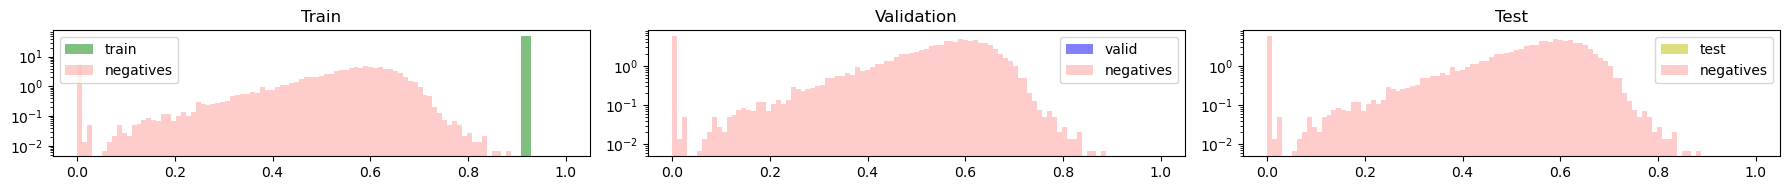

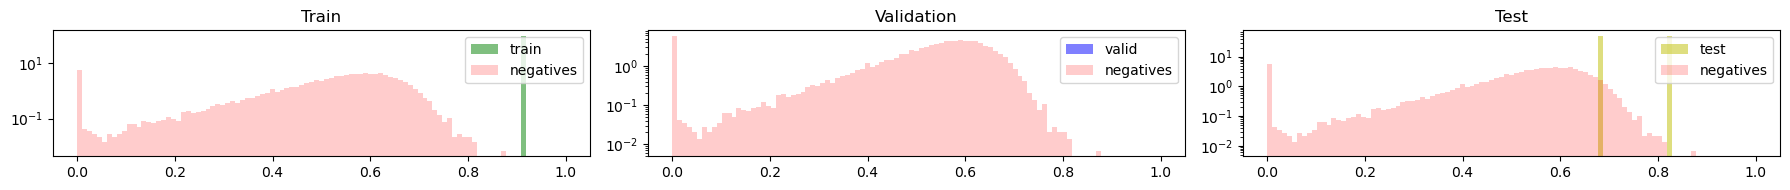

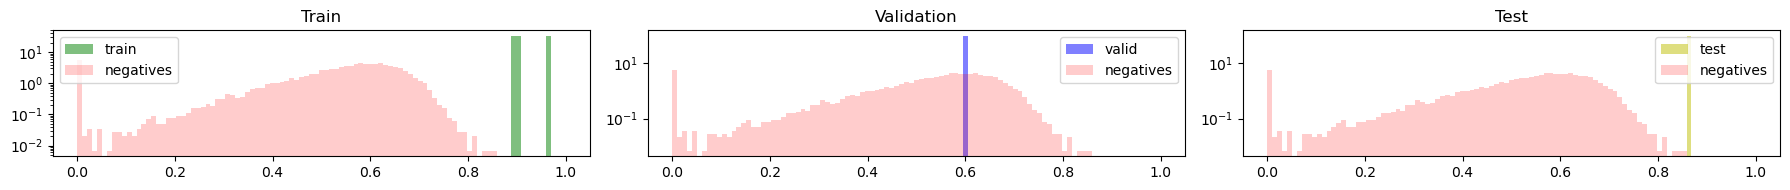

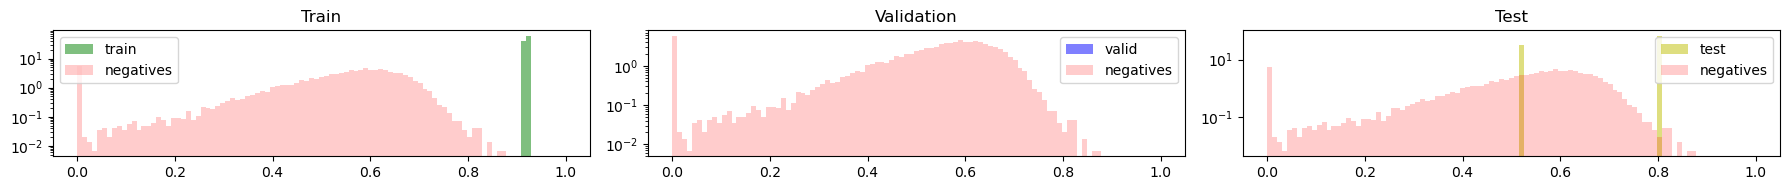

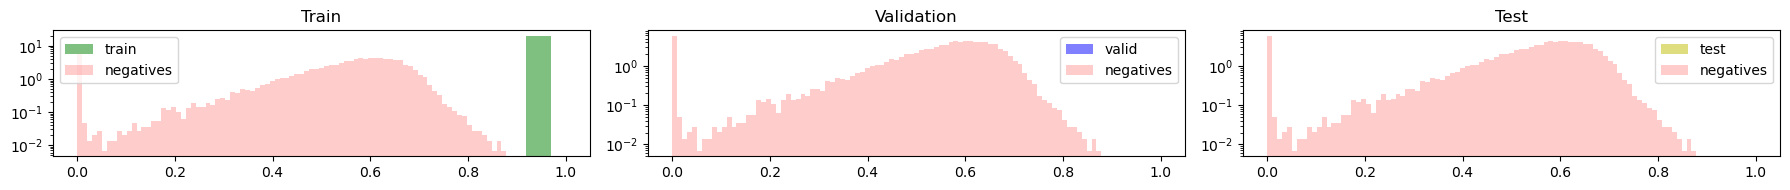

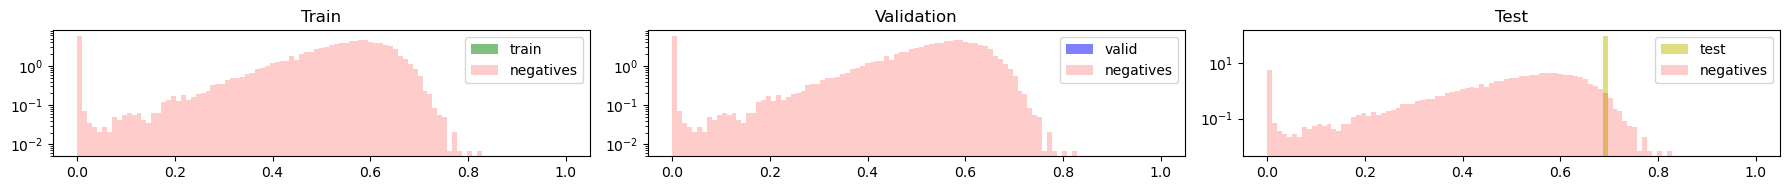

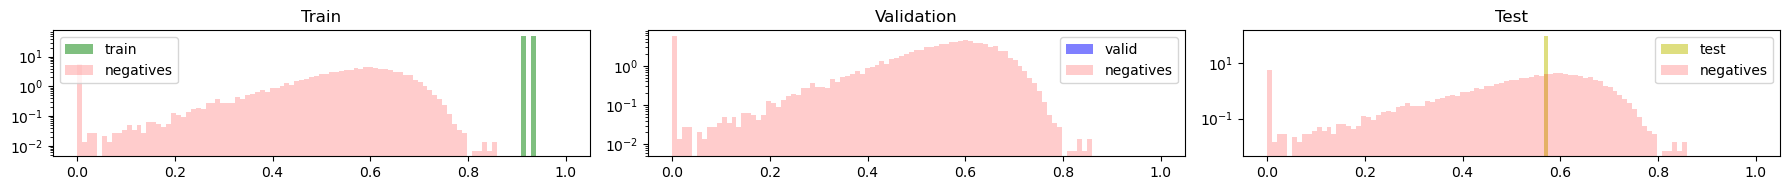

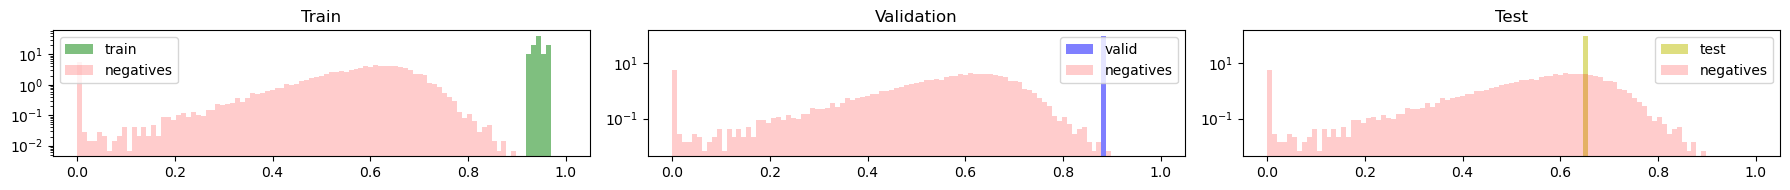

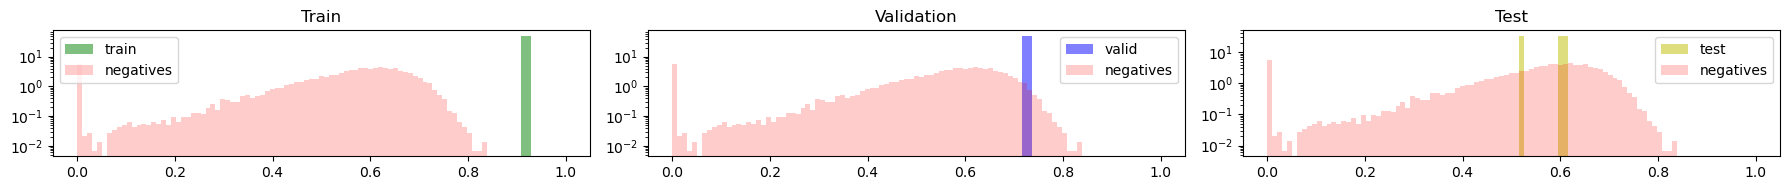

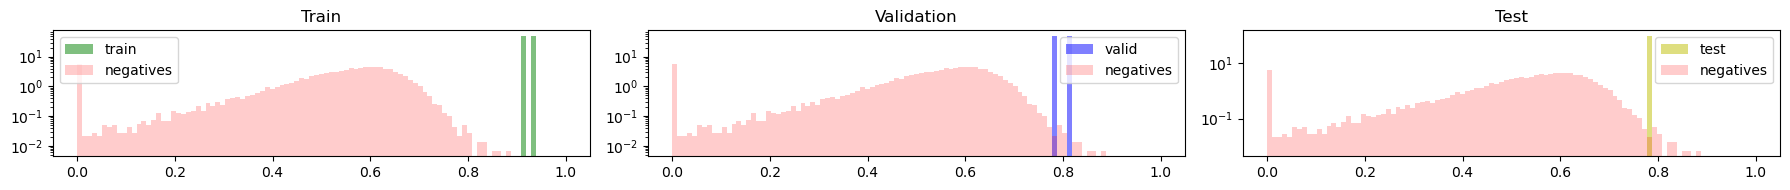

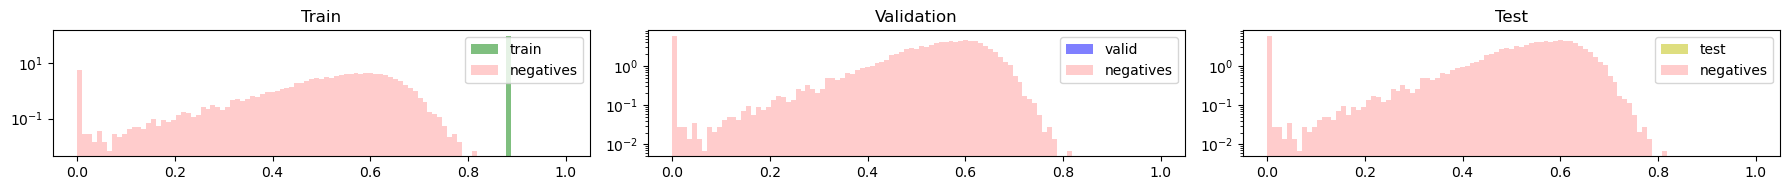

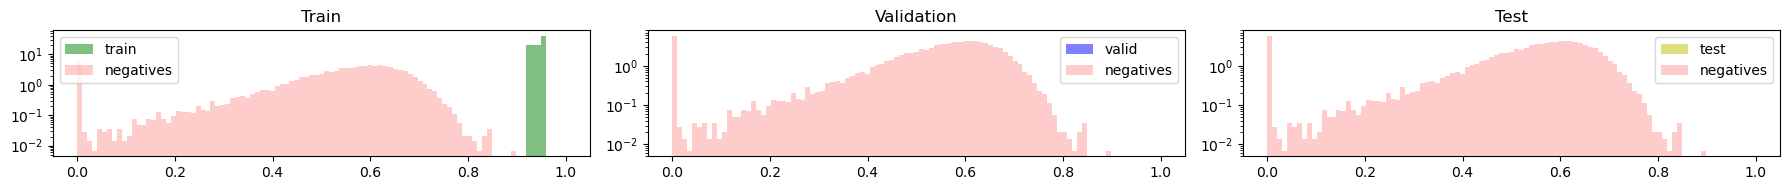

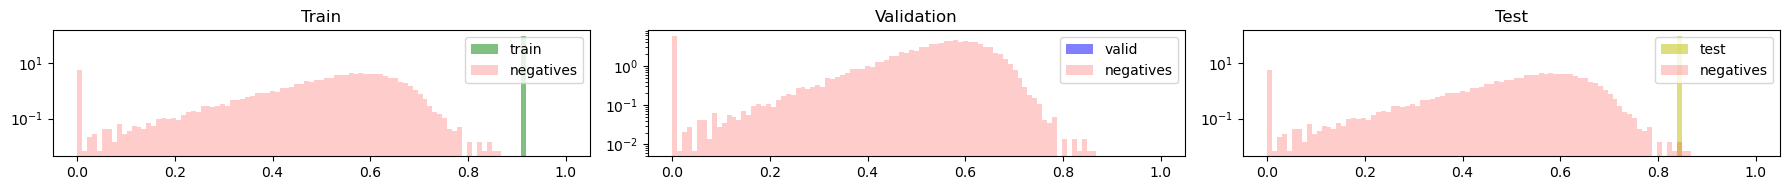

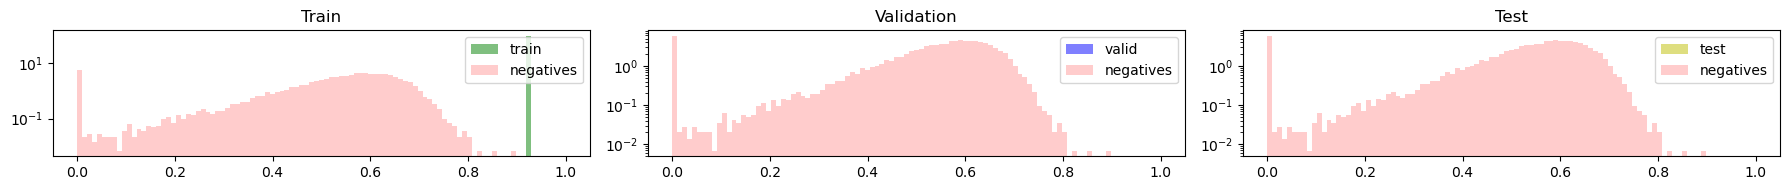

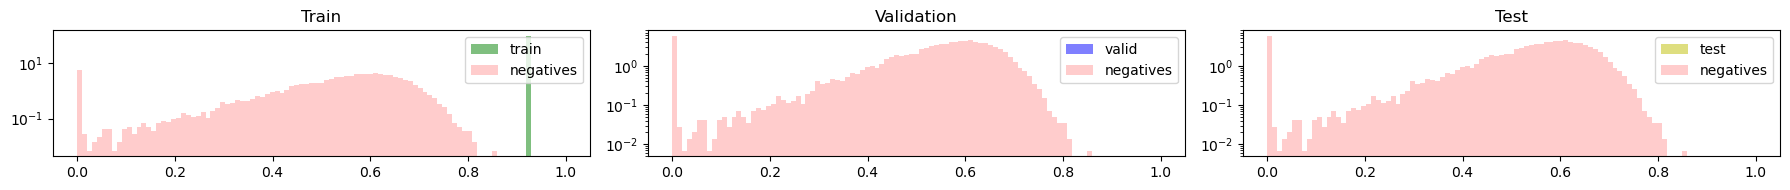

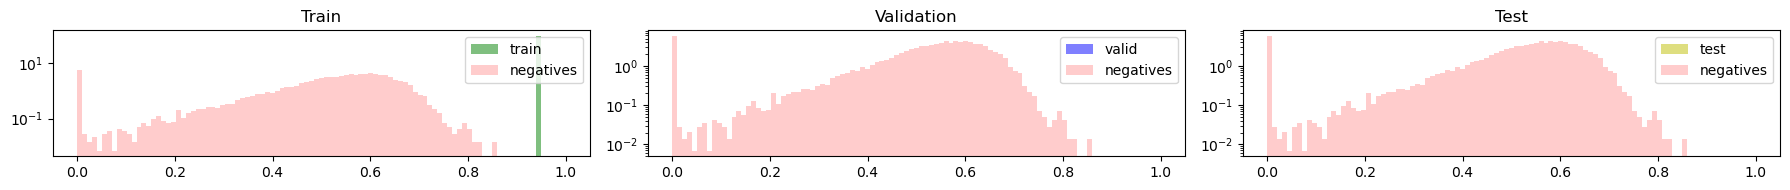

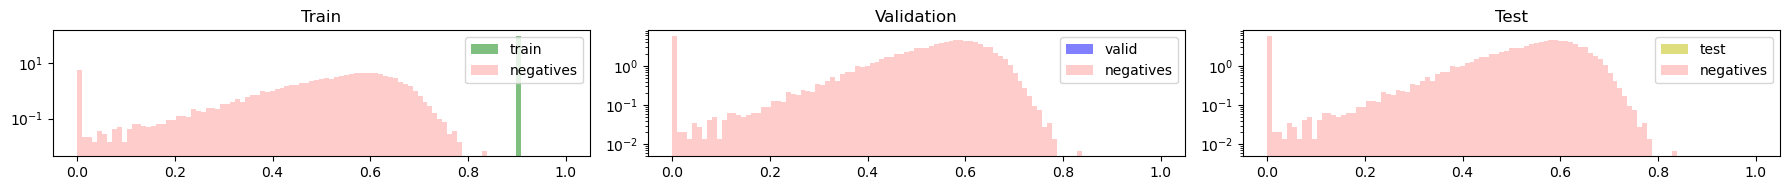

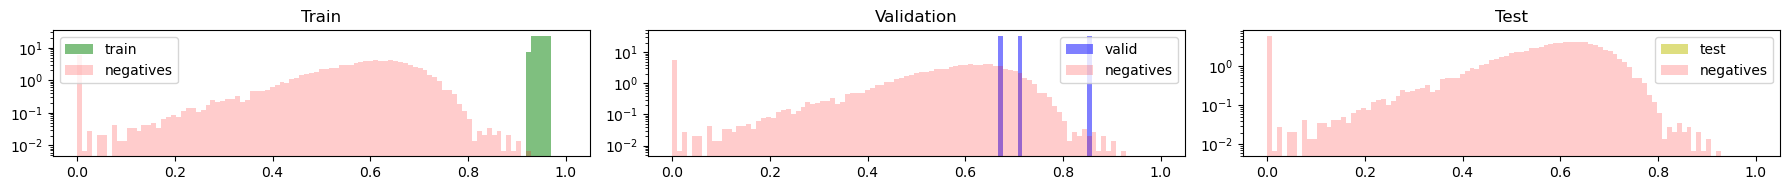

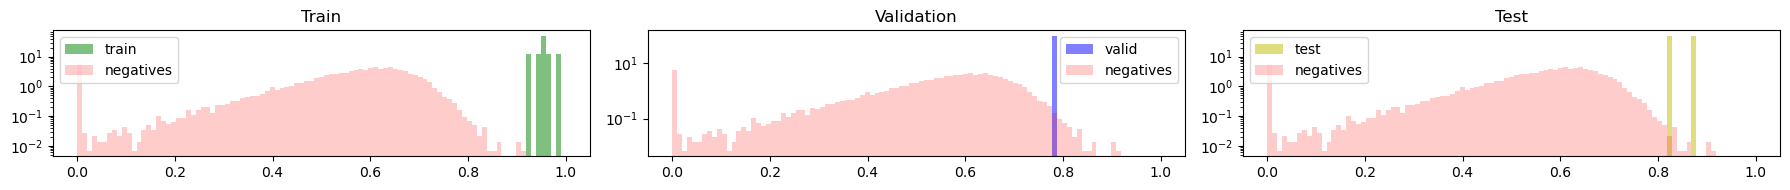

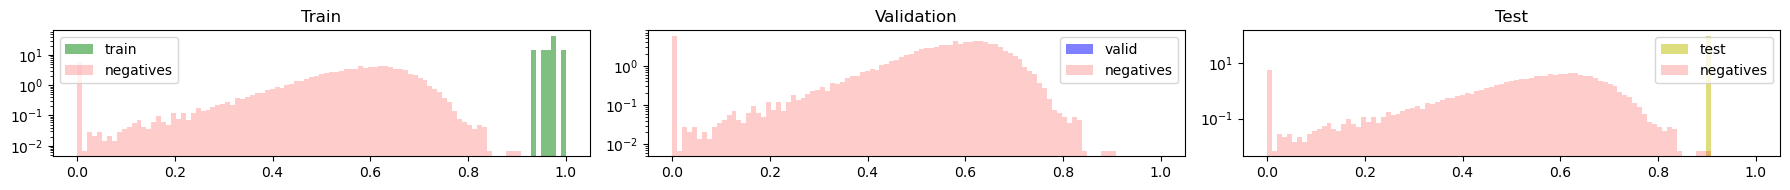

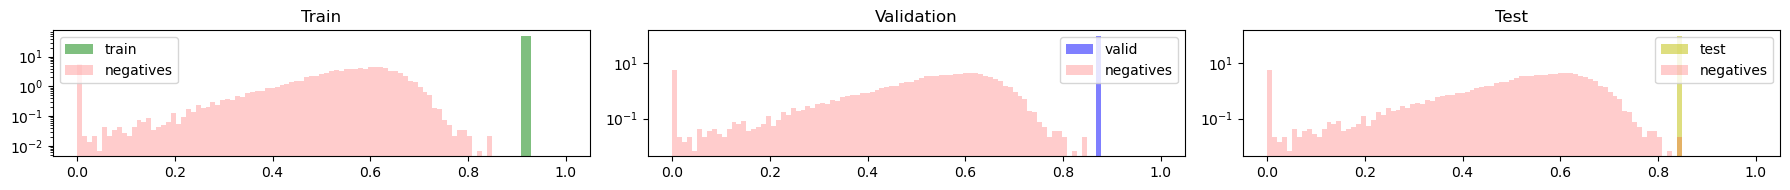

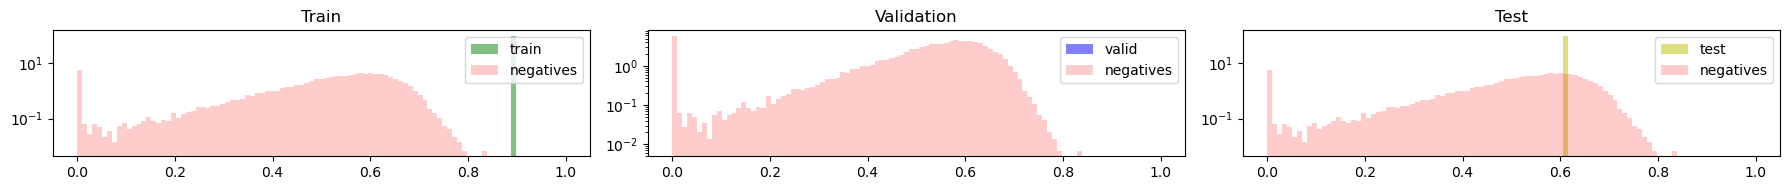

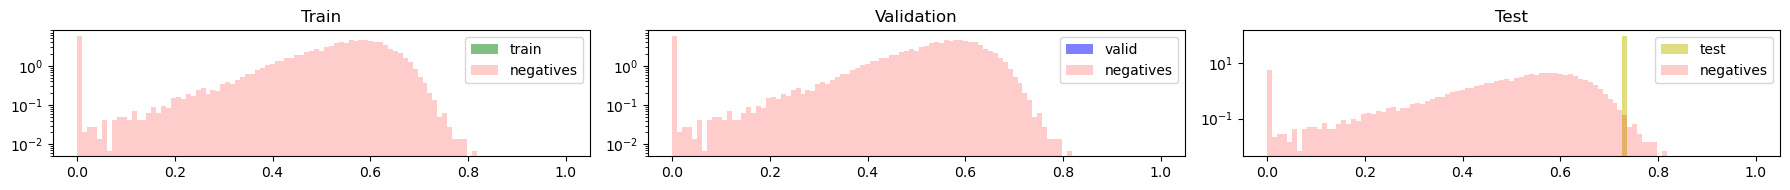

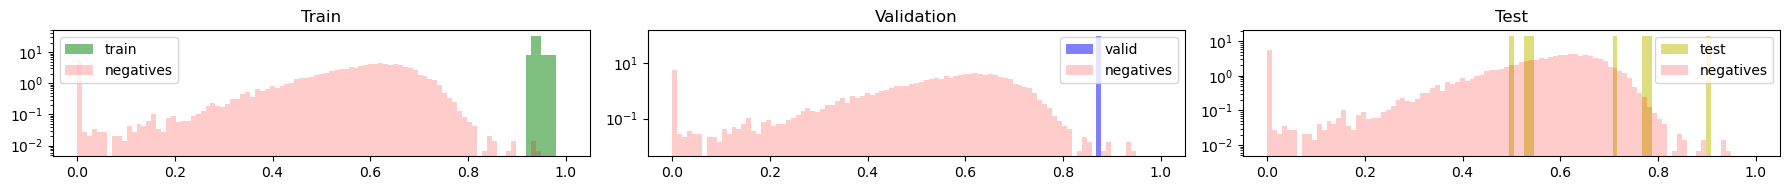

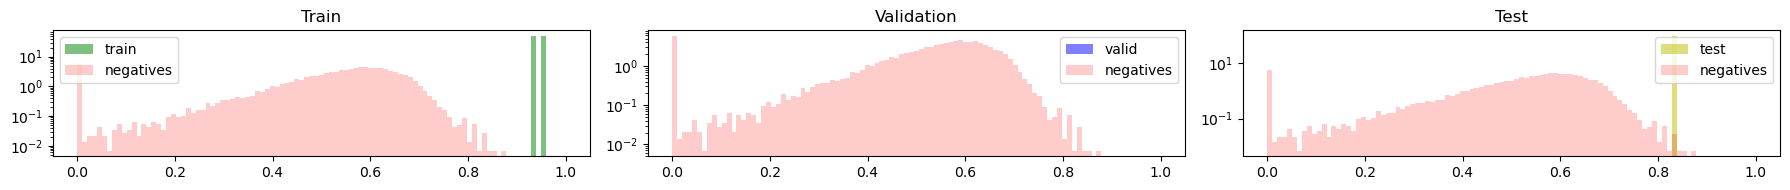

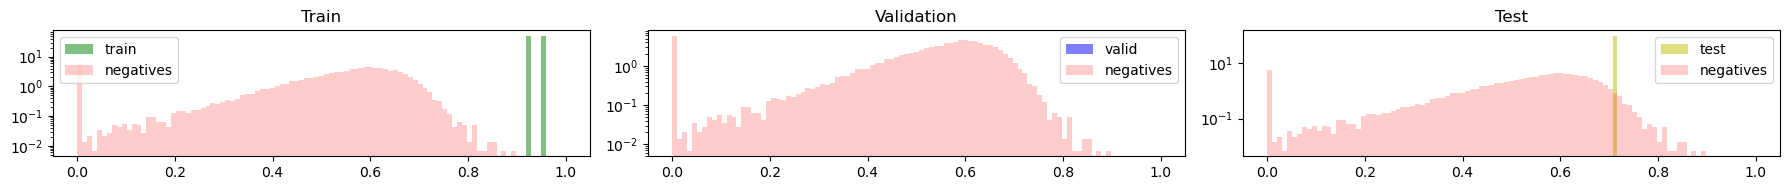

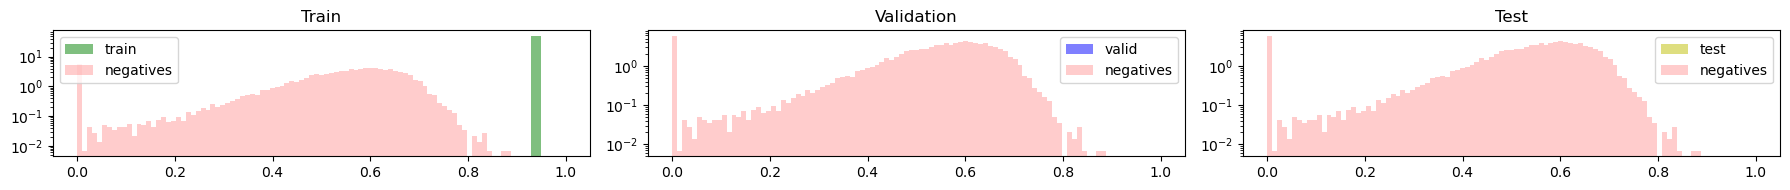

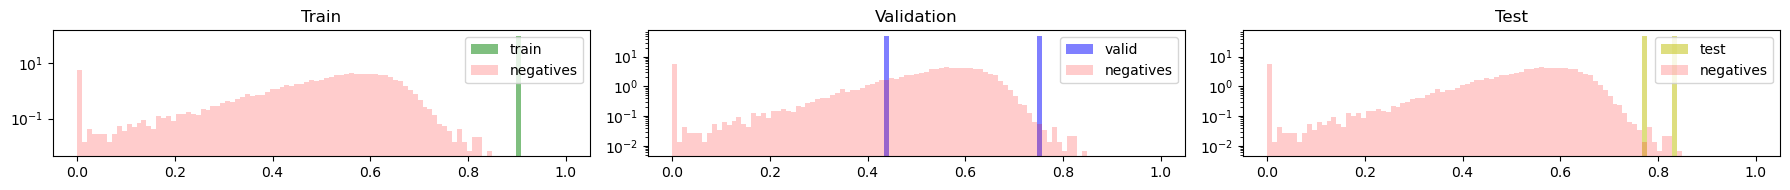

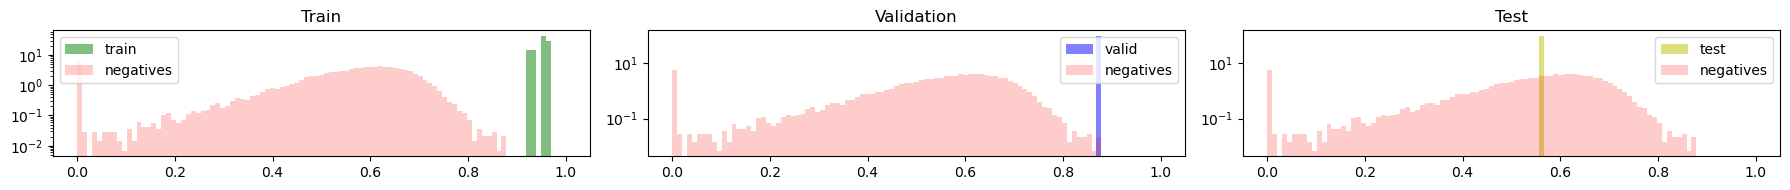

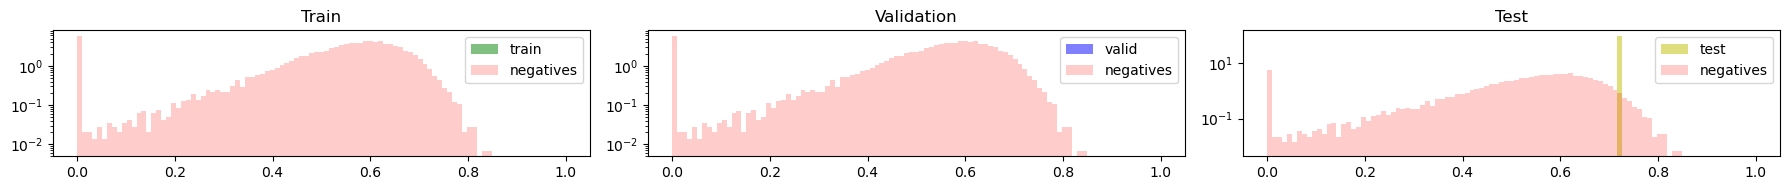

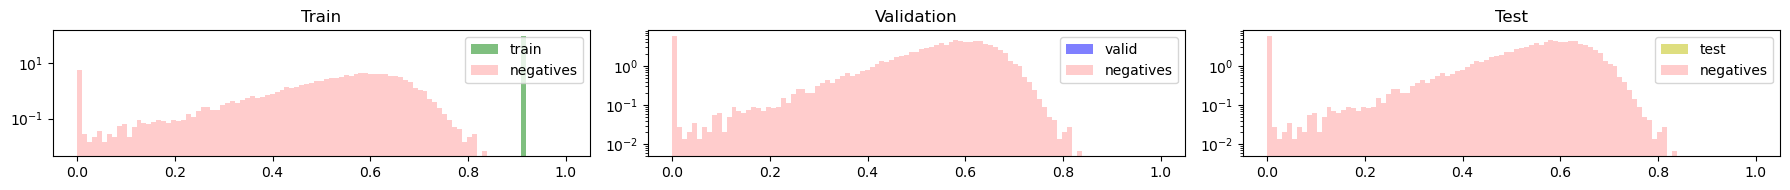

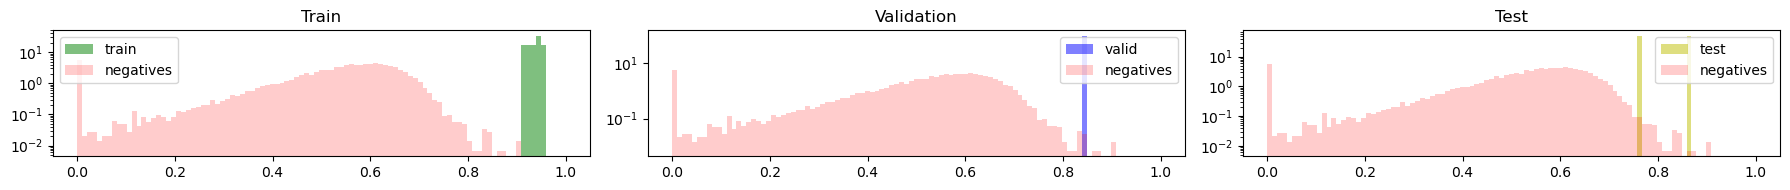

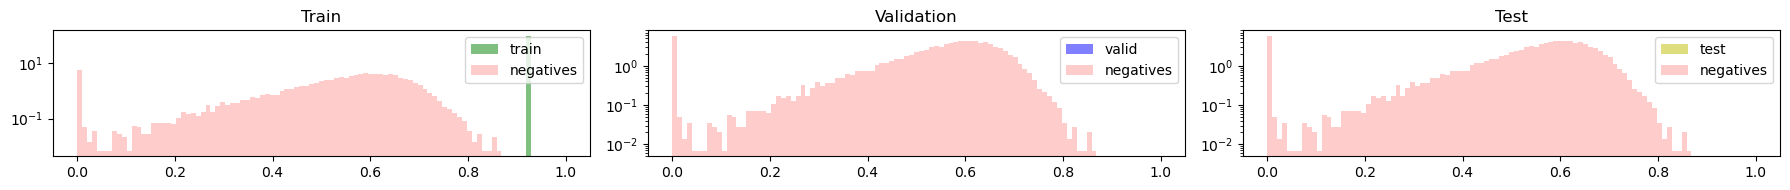

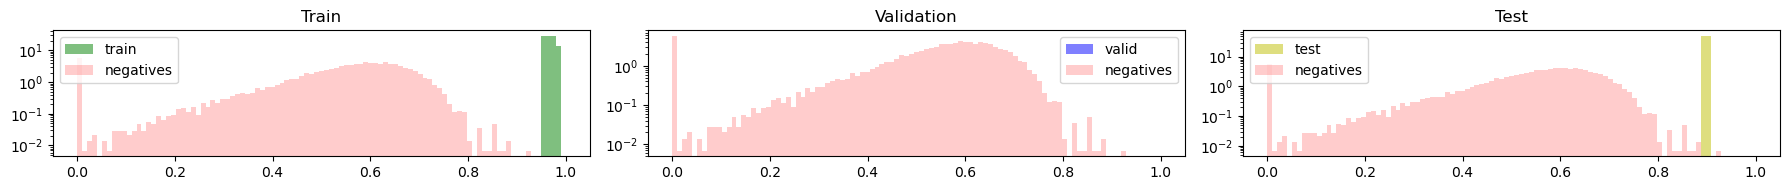

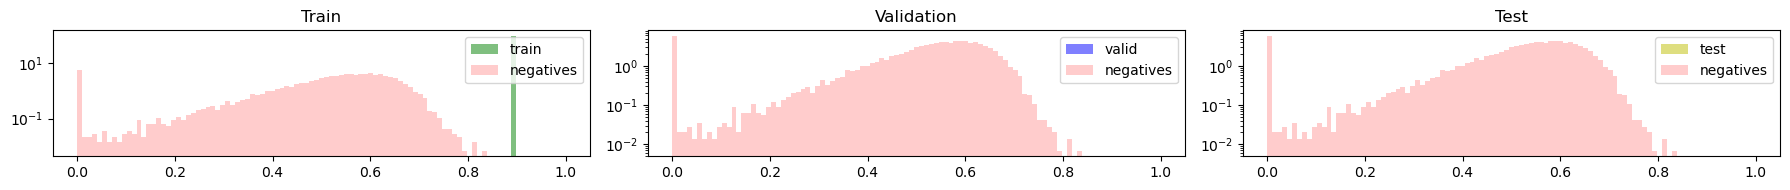

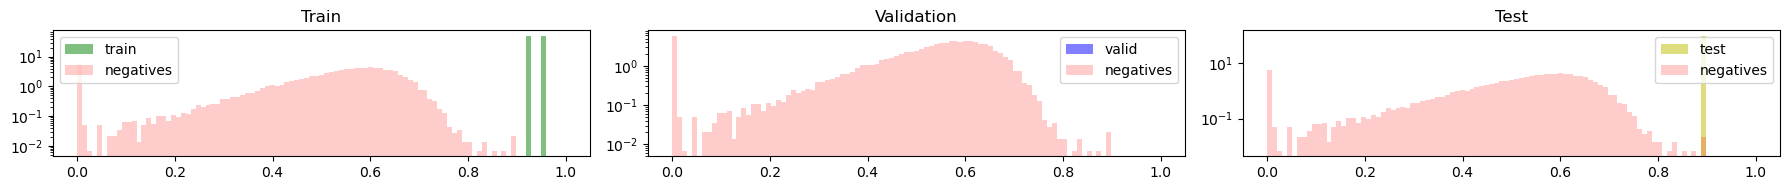

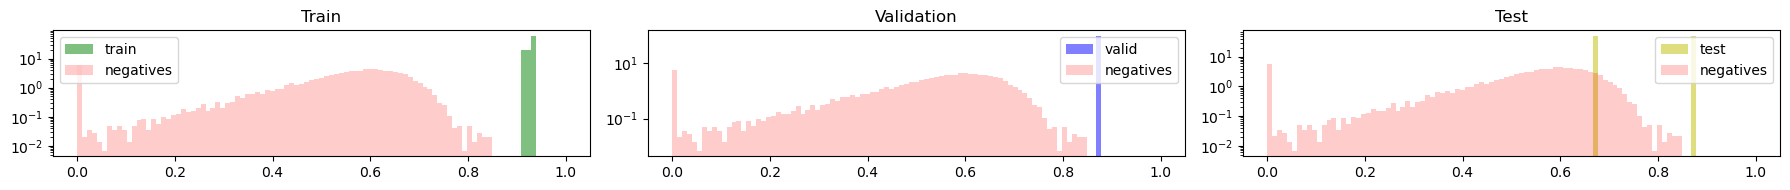

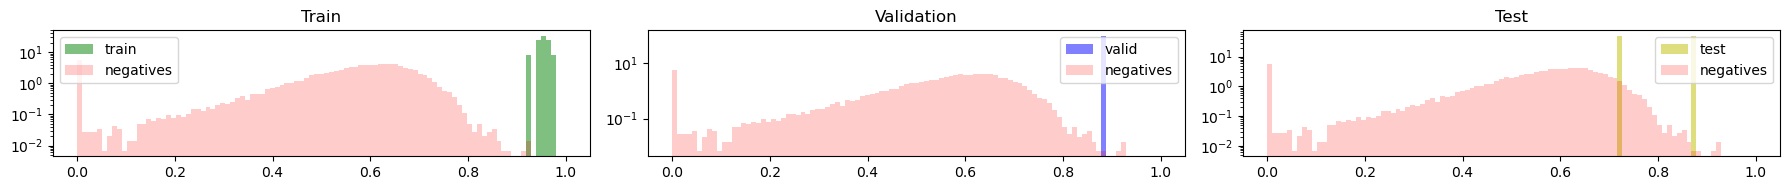

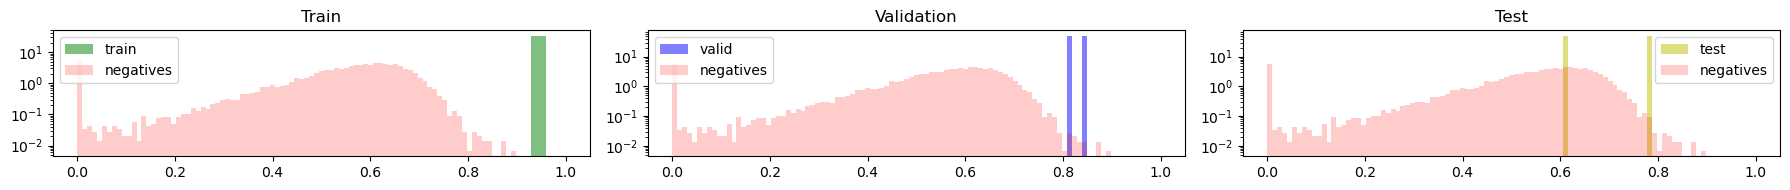

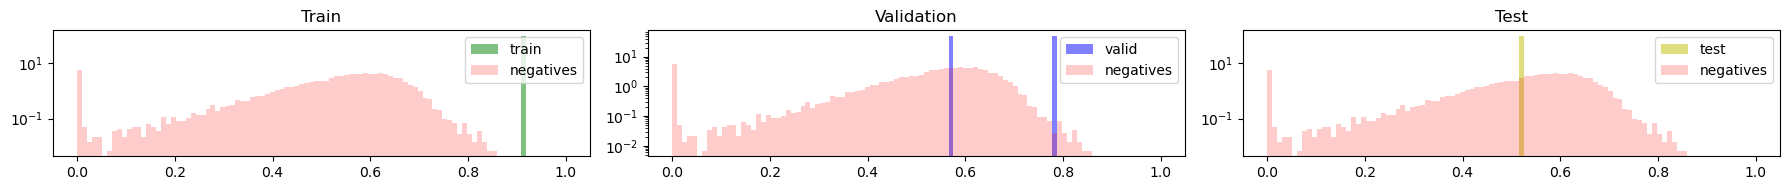

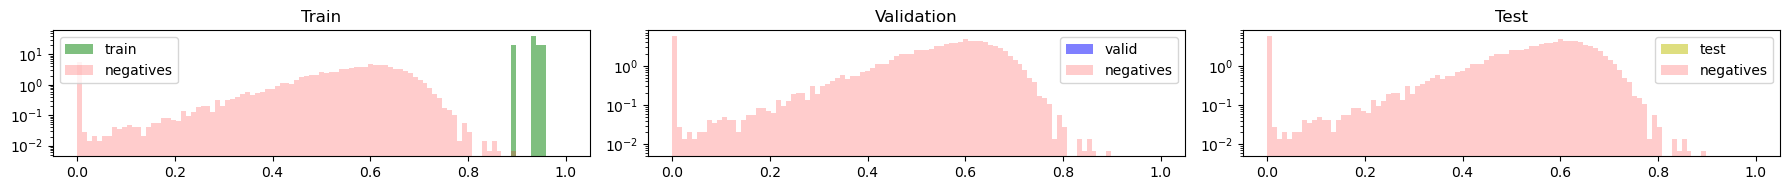

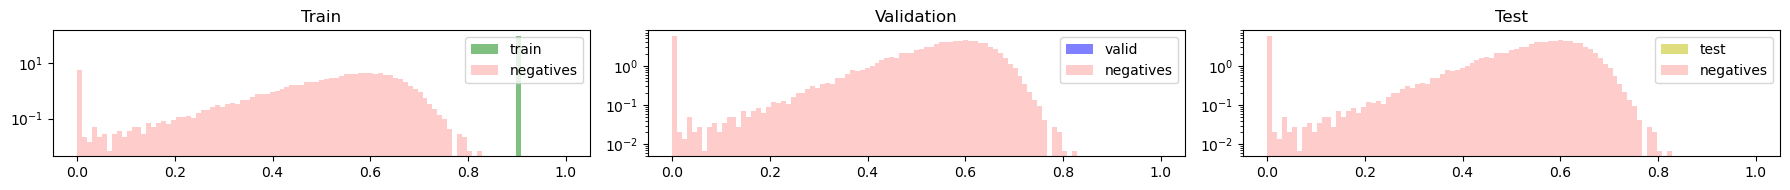

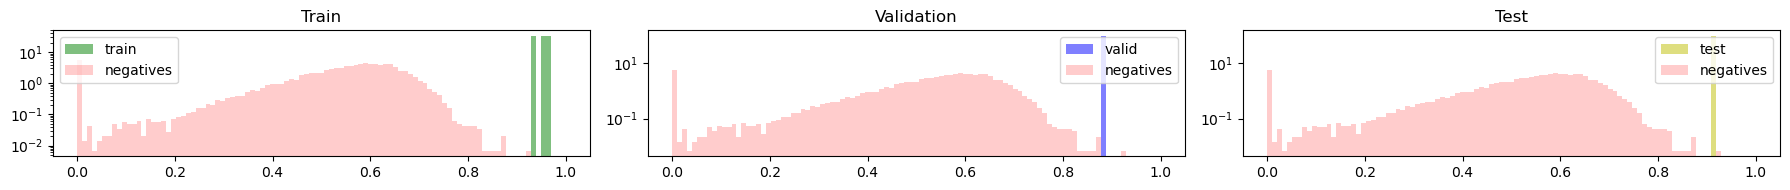

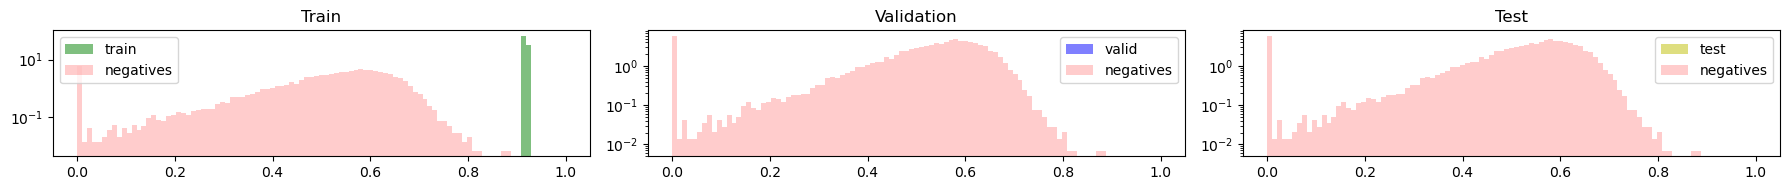

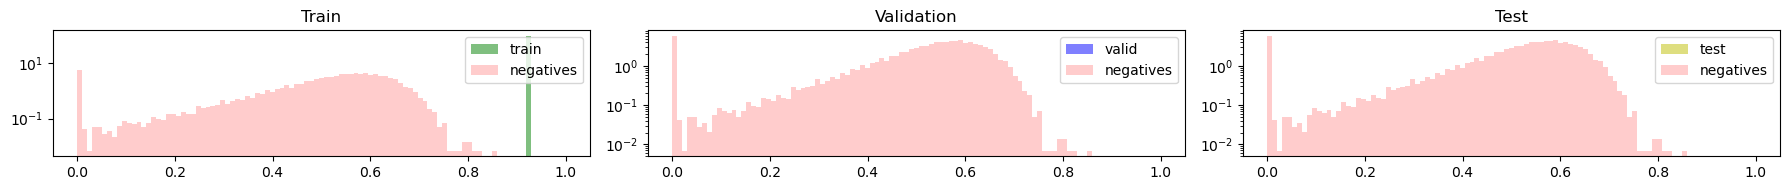

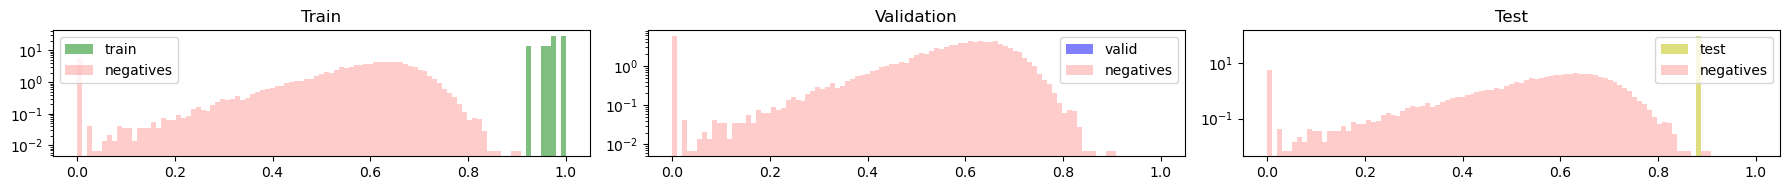

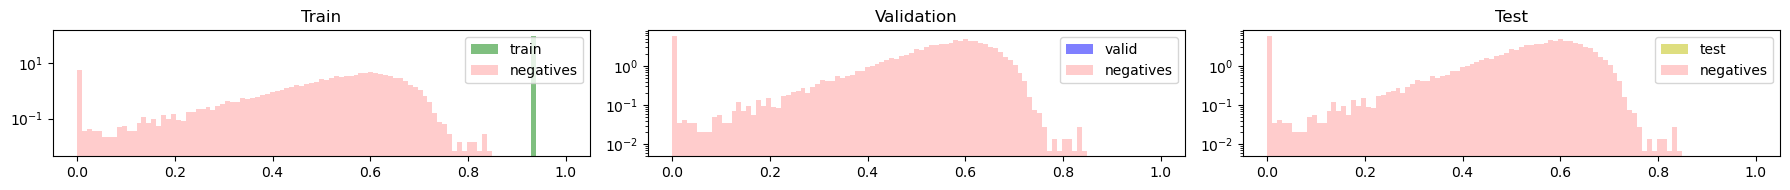

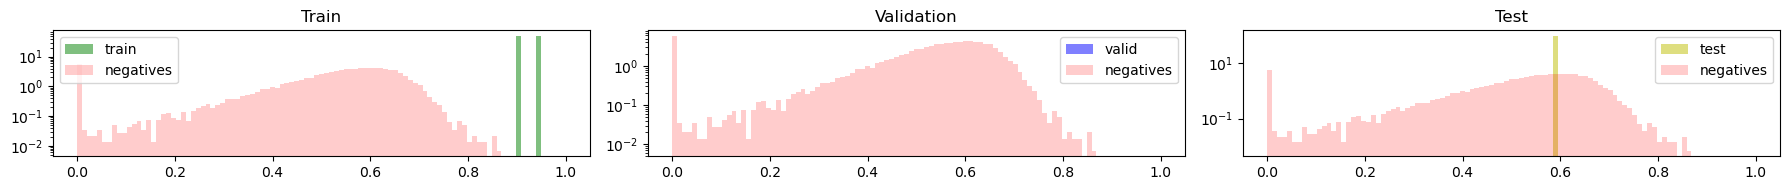

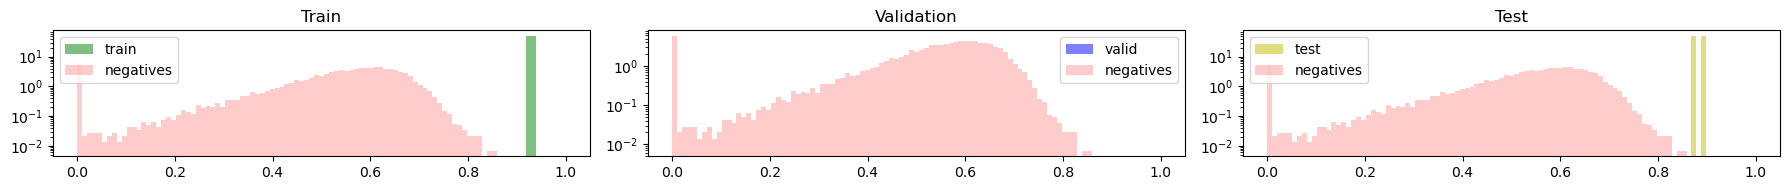

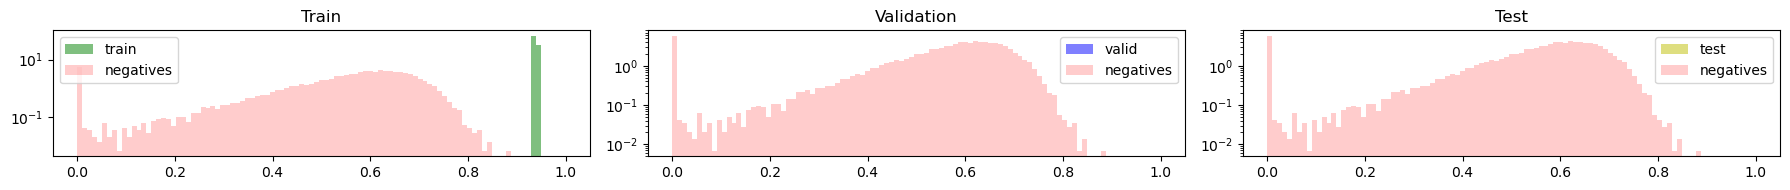

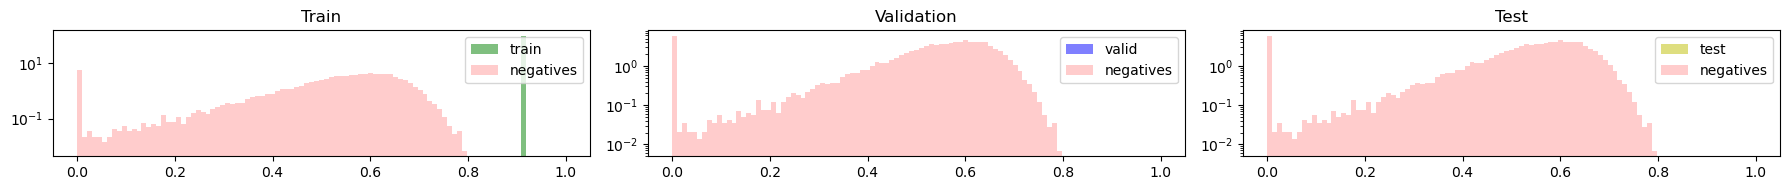

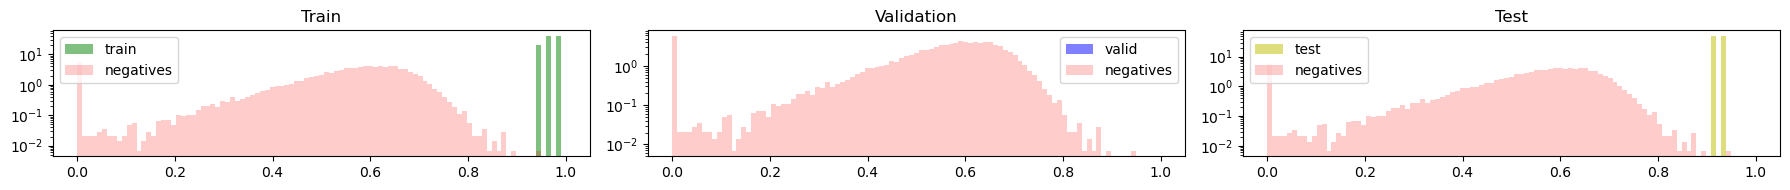

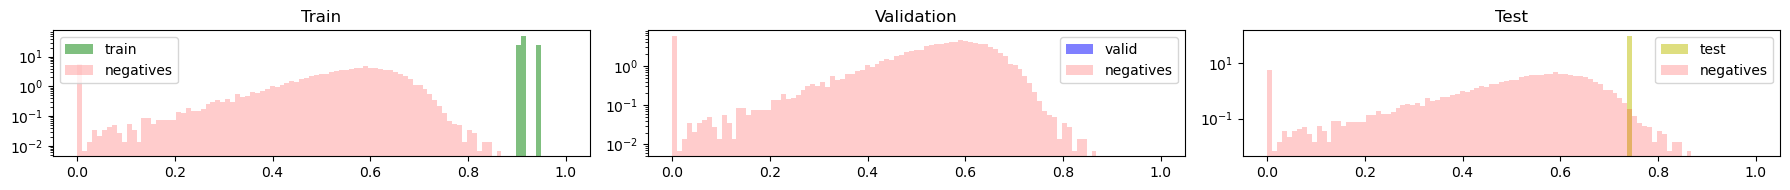

In [ ]:
for drug in preds.drug_name.unique(): 
    tmp = preds[preds.drug_name == drug] 
    plot_hists(tmp, figsize=(18, 2), density=True)

In [ ]:
# Get the maximum indices for drugs and proteins
max_drug_idx = preds['drug'].max() + 1
max_protein_idx = preds['protein'].max() + 1

# Initialize the dense matrix with zeros
A = np.zeros((max_drug_idx, max_protein_idx))

# Populate the matrix with probabilities
for _, row in preds.iterrows():

    A[row['drug'], row['protein']] = row['prob']


/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

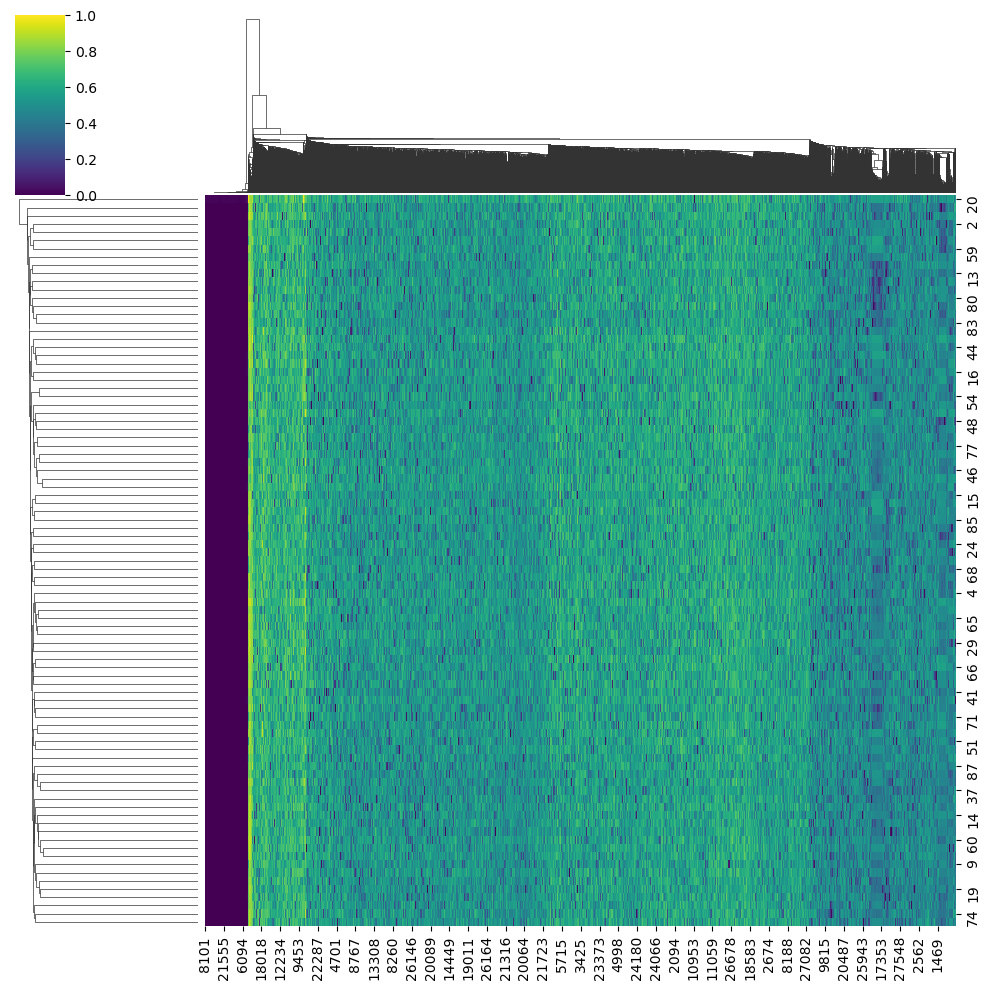

In [ ]:
plt.figure()
sbn.clustermap(A, cmap='viridis', figsize=(10, 10))